### Kmean to find which points train together

In [2]:
import os
import yaml
import pickle as pkl
import netCDF4 as nc4

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from datetime import date
import random

from src.utils import save_name
from src.utils import reload_config
import src.data_preparation.load_data as load_data

import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

In [3]:

file_config = '../config/data_proc_full.yaml'

conf = reload_config.Config(file_config, rootdir=rootdir, verbose=1)

Config file found: ../config/data_proc_full.yaml
PCA results in: /scratch/project_465000269/edelleo1/Leo/results/pca_i100-550_j300-629
Config file updated 'pca_dir': ../config/data_proc_full.yaml
Results in: /scratch/project_465000269/edelleo1/Leo/results/xgb_230213-172909
Folder created

Subfolder created: /scratch/project_465000269/edelleo1/Leo/results/xgb_230213-172909/ml/
Subfolder created: /scratch/project_465000269/edelleo1/Leo/results/xgb_230213-172909/figures/
Config file updated 'results_dir': ../config/data_proc_full.yaml
Config folders updated.
Old config files, some <ml> parameters are not imported.
Old config files, <dataset> parameters are not imported.
Config copied to: /scratch/project_465000269/edelleo1/Leo/results/xgb_230213-172909
Config file found: /scratch/project_465000269/edelleo1/Leo/results/xgb_230213-172909/data_proc_full.yaml
Default config file is now the copied following one:
/scratch/project_465000269/edelleo1/Leo/results/xgb_230213-172909/data_proc_full.y

## get difference between topaz4b and GLOBAL ML

In [3]:
# load from .nc :

# bias after global correction
# chrono


In [4]:
# get land mask in order to remove land (nan value)
# Import forcings (without PCA) // and covariables

In [6]:
Xeg, chrono, Xna, covar, forcings, maskok = load_data.load_dataset_g2l(conf)

In [7]:
covar['siconc']

<xarray.DataArray 'siconc' (time: 3000, y: 329, x: 450)>
[444150000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2019-12-17
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
  * x          (x) float32 -25.5 -25.38 -25.25 -25.12 ... 30.25 30.38 30.5 30.62
  * y          (y) float32 -17.5 -17.38 -17.25 -17.12 ... 23.12 23.25 23.38 23.5
Attributes:
    cell_methods:   area: mean
    grid_mapping:   stereographic
    standard_name:  sea_ice_area_fraction
    units:          1

In [8]:
sia

<xarray.DataArray 'sia' (time: 3014, y: 329, x: 450)>
[446222700 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2019-12-31
  * y        (y) float64 -1.75e+06 -1.738e+06 -1.725e+06 ... 2.338e+06 2.35e+06
  * x        (x) float64 -2.55e+06 -2.538e+06 -2.525e+06 ... 3.05e+06 3.062e+06
Attributes:
    long_name:  Averaged sea ice age

In [5]:
# get sia ice age (Anton) and add it to covar


idir = f'{rootdir}/Leo/sia/'
ifile = 'Topaz_arctic25km_sea_ice_age_v2p0_20111001_20191231.nc'


nc = nc4.Dataset(f'{idir}{ifile}', mode='r')
sia = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sia'] 

# trunc time dimension

In [6]:
def dico_np2xr(dico, coo1, coo2, coo3):
    '''Convert a dictionnary containing 3D ndarray to 3D xr.DataArray
    
    Parameters:
    ------------
        dico      : dictionnary containing 3D ndarray (i.e. forcings)
        coo1      : coords 1:time, DataArray of dim 1
        coo2      : coords 2:y, DataArray of dim 1
        coo3      : coords 3:x, DataArray of dim 1
    '''

    new_dico = dict()
    for ky in dico:
        new_dico[ky] = xr.DataArray(dico[ky], coords={'time':coo1, 'y':coo2, 'x':coo3}, dims=['time','y','x'])
    
    return new_dico

In [7]:
# Converting forcings to xr.DataArray
forcings = dico_np2xr(forcings, Xeg['time'], Xeg['y'], Xeg['x'])

## Compute the area

In [8]:
def get_area(data, lim_idm, lim_jdm, index_mask, keep=[]):
    """ Keep only data for the given geographical zone
    In:
        data        : dict or xarray.core.dataset.Dataset -- Data to process
        lim_idm     : tuple                               -- limits of the geographical area to be preserved (following axes x)
        lim_jdm     : tuple                               -- limits of the geographical area to be preserved (following axes y)
        index_mask  : numpy.ndarray                       -- mask to apply for nonan if needed (ex: for forcings nonan to keep)
        keep        : String list                         -- Parameters values to keep in data
        
    Out:
        X_sel       : dict -- key = field name, value = (y, x) array, data array restricted to the given geographical area and mean over time, reversed data if rev
        X_sel_nonan : dict -- same than Xm_sel without NaN values
    """
    
    X_sel = dict()
    X_sel_nonan = dict()
    
    t = data[keep[0]].shape[0]
    n = index_mask.shape[1]
    
    for field in keep:
            X_sel[field] = data[field].sel(jdim=slice(*lim_jdm),idim=slice(*lim_idm)).values
            X_sel_nonan[field] = X_sel[field][np.isfinite(X_sel[field])]
            X_sel_nonan[field] = np.reshape(X_sel_nonan[field], [t, n])

    return X_sel, X_sel_nonan


In [9]:
# Covariables and forcings to evaluate
keep_cov = conf.covar_fields
keep_fg = conf.forcing_fields

nb_vars = len(keep_cov) + len(keep_fg)

In [10]:
def remove_nan(dico, mask, keep=[]):
    """ Remove nan value using masked values (index_mask), corresponding to the land where SIT data is available
    
    Parameters:
    -----------
    
        dict          : dictionnary containing multiples covar or forcings, each with shape (time, x, y)
        mask          : 2D xarray, land/ocean mask  (False on land)
        keep          : name of variables for which to remove NaN
                        if default (empty), all variables will be processed
    """
    
    if len(keep)==0:
        keep = dico.keys()
    
    dict_nonan = dict()
    
    dkey = list(dico.keys())[0]  # default key from dico
    # nt = dico[dkey].shape[0]  # number of timesteps
    
    mask_3d = np.broadcast_to(mask==True, dico[dkey].shape)  # from 2d to 3d mask
    
    for field in keep:  # loop on var in dico
        tmp = xr.where(mask_3d, dico[field], np.nan)  # apply mask
        stacked = tmp.stack(n=('y','x'))  # reshape
        dict_nonan[field] = stacked.dropna('n')  # remove NaN    

    return dict_nonan

In [11]:
print('Removing Nan...')
covar_nonan = remove_nan(covar, maskok)
forcings_nonan = remove_nan(forcings, maskok)

Removing Nan...


In [12]:
def xr_remove_nan(arr, mask):
    mask_3d = np.broadcast_to(mask==True, arr.shape)  # from 2d to 3d mask

    tmp = xr.where(mask_3d, arr, np.nan)  # apply mask
    stacked = tmp.stack(n=('y','x'))  # reshape
    return stacked.dropna('n', 'all')  # remove NaN    

In [13]:
Xeg_nonan = xr_remove_nan(Xeg, maskok)

In [14]:
def corr_dico_bias(covar, forcings, Xe):
    '''Correlation along dimension 'time'
    
    Parameters:
    ------------
        covar         : same as below
        forcings      : dictionnary containing multiple DataArray (time, n)
        Xe            : Xeg_nonan, DataArray shape (time, n)
    '''
    
    # todo: add check DataArray with 'time' in dims  
    
    nvar = len(covar.keys()) + len(forcings.keys())
    corr = np.ones((Xe.shape[1], nvar)) * -1
    
    for idx, field in enumerate(covar.keys()):
        corr[:, idx] = xr.corr(covar[field], Xe, dim='time')
    
    for idx, field in enumerate(forcings.keys()):
        corr[:, len(covar.keys())+idx] = xr.corr(forcings[field], Xe, dim='time')
    
    return corr

In [15]:
def refill_wnan(array, maskok1d):
    new_arr = np.zeros((maskok1d.shape[0]))
    
    new_arr[~maskok1d] = -1
    new_arr[maskok1d] = array
    
    return new_arr

In [16]:
print('Computing correlation...')
corr = corr_dico_bias(covar_nonan, forcings_nonan, Xeg_nonan)

Computing correlation...


Correlation average over all time line ? 
how does the correlation evolve for each month ? (plot it!)
As SI extend moves, it probably makes sense to use a monthly/seasonal Kmeans.

In [17]:
# Remove NaN values due to correlation computation (Open ocean, constant error...)

In [18]:
nan_idx = np.unique(np.where(np.isnan(corr))[0])
nonan_mask = np.full((corr.shape[0]), True)
nonan_mask[nan_idx] = False  # put False where NaN

# we lose 10 000 points: mostly open sea
# exclude indexes with Nan due to correlation computation (constant error etc)

## corr_nonan = np.empty([np.count_nonzero(nonan_mask), nb_vars])
##for i in range(nb_vars):
##    corr_nonan[:, i] = corr[:, i][nonan_mask]

In [19]:
corr_nonan = corr[nonan_mask]

In [20]:
# ---------------------------
# compute kmean areas
use_kmean = True
use_dbscan = not use_kmean
if use_kmean:
    n_clusters = 40
    print('Computing Kmean clusters...')
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(corr_nonan[:200])
    y_kmeans = kmeans.predict(corr_nonan[:200])

if use_dbscan:
    from sklearn.cluster import DBSCAN
    print('Computing DBSCAN clusters...')
   # import pdb; pdb.set_trace()
    
    db = DBSCAN(eps=0.45, min_samples=10).fit(corr_nonan)
    y_kmeans = db.labels_

    # Indications of results
    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(y_kmeans)) - (1 if -1 in y_kmeans else 0)
    n_noise_ = list(y_kmeans).count(-1)

    print(f"Estimated number of clusters: {n_clusters}")
    print(f"Estimated number of noise points: {n_noise_} over {y_kmeans.size} points")
    # import pdb; pdb.set_trace()

Computing Kmean clusters...


In [ ]:
# TODO: plot with annotations to the center of the CLUSTER
# or a clear way to know the number

In [25]:
# add the nan back:
# Put back -999, where NaN values due to correlation computation (constant error etc)

yk_wn = np.zeros((corr.shape[0])) # non nan y Kmean

yk_wn[~nonan_mask] = -999
yk_wn[nonan_mask] = y_kmeans

ValueError: NumPy boolean array indexing assignment cannot assign 200 input values to the 66563 output values where the mask is true

## ----------------------------------------------------------------------------------------------

In [23]:
maskok1d = maskok.data.reshape((maskok.shape[0]*maskok.shape[1]))

In [24]:
# adding nan values from mask land/ocean
yk_full = refill_wnan(yk_wn, maskok1d)

# reshaping
km = yk_full.reshape((329, 450))

In [25]:
# kk[np.where(kk==-1)] = np.nan

# kk[np.where(kk==-999)] = np.nan

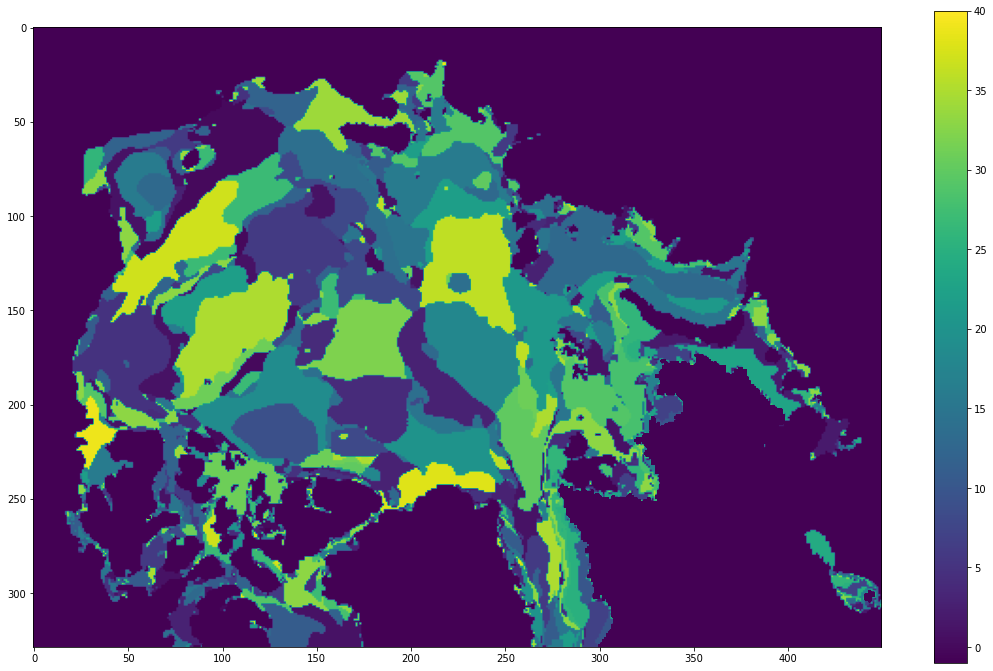

In [26]:
fig, ax = plt.subplots(figsize=(19,12))
plt.imshow(km[::-1], vmin=-1, vmax=n_clusters)
plt.colorbar()

In [27]:
# convert to DataArray
km_xr = xr.DataArray(km, coords={'y':Xeg['y'], 'x':Xeg['x']}, dims=['y', 'x'])

# fig, ax = plt.subplots(figsize=(19,12))
# km_xr.plot(vmin=-1, vmax=n_clusters)

In [28]:
y_kmeans.shape

(66563,)

In [32]:
km_from_func = unflatten_addNaN(y_kmeans, maskok1d, nonan_mask)

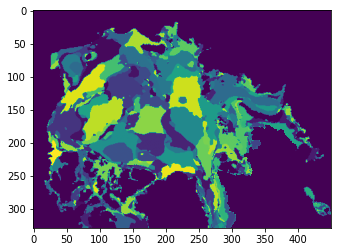

In [33]:
plt.imshow(km_from_func[::-1], vmin=-1)

In [30]:
def unflatten_addNaN(corr, maskok1d, nonan_mask):
    '''Add Nan from bad correlation computation, add Nan from Land/ocean mask
    reshape (y,x)
    
    Parameters:
    -----------
    
        corr      : array to modify
        maskok1d  : land/ocean mask in 1D array
        nonan_mask: mask of nan from bad correlation computation
        
    
    '''
    
    # first for 1 array
    #corr.shape == (76xxx)
    
    yk_wn = np.zeros((nonan_mask.shape[0])) # non nan y Kmean
    yk_wn[~nonan_mask] = -999
    yk_wn[nonan_mask] = corr
    
    yk_full = refill_wnan(yk_wn, maskok1d)
    km = yk_full.reshape((329, 450))  # hardcoded
    
    return km
    

In [34]:
def corr_1d_to_2d(corr, maskok1d, nonan_mask):
    '''Add -999 when NaN from bad correlation computation, add Nan from Land/ocean mask
    reshape (y,x)
    
    Parameters:
    -----------
    
        corr      : array to modify shape (number of pixel on ocean, number of variables)
        maskok1d  : land/ocean mask in 1D array
        nonan_mask: mask of nan from bad correlation computation
        
    
    '''
    corr[~nonan_mask] = -999
    
    arr_full = np.zeros((maskok1d.shape[0], corr.shape[1]))
    
    for i in range(corr.shape[1]):
        arr_full[:, i] = refill_wnan(corr[:, i], maskok1d)
    
    corr2D = arr_full.reshape((329, 450, corr.shape[1]))  # hardcoded: (329, 450) = (y, x)
    
    return corr2D
    

In [35]:
corr_from_func = corr_1d_to_2d(corr, maskok1d, nonan_mask)

In [36]:
corr_from_func.shape

(329, 450, 12)

In [37]:
# create new coords
nvar_names = list(covar.keys())+list(forcings.keys())
nvar = np.arange(len(nvar_names))


In [38]:
corr2d_xr = xr.DataArray(corr_from_func, coords={'y':Xeg['y'], 'x':Xeg['x'], 'nvar':nvar_names}, dims=['y', 'x', 'nvar'])

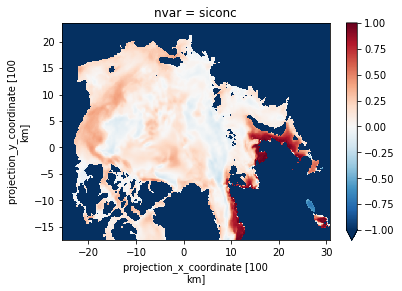

In [39]:
corr2d_xr[:,:,0].plot(vmin=-1)

## -----------------

## Save results (kmean and correlation) to .nc

In [40]:
km_xr.attrs['standard_name'] = 'kmean'
corr2d_xr.attrs['standard_name'] = 'correlation'

In [41]:
ds_km_xr = xr.Dataset(data_vars={'km':km_xr,
                                 'corr':corr2d_xr},
                     attrs=dict(
                         description='Kmean based on correlation between <bias> from GLOBAL reconstruction '
                         + 'and TOPAZ4b FreeRun and <covariables and forcings>',
                         n_clusters=f'{n_clusters}',
                         model_ml='GLOBAL reconstruct made by rf_221216-141433',
                         author='Leo Edel, Nersc',
                         project='TARDIS',
                         date=f'{date.today()}'
                     ))

In [42]:
ofile = f'Kmean_n{n_clusters}_2011_2019.nc'
ds_km_xr.to_netcdf(f'{conf.rootdir}{conf.ml_dir}{ofile}')
print(f'Saved as: {conf.rootdir}{conf.ml_dir}{ofile}')

Saved as: /nird/projects/nird/NS2993K/Leo/results/xgb_230130-135907/ml/Kmean_n40_2011_2019.nc


## Load the kmean computation 

In [1]:
n_clusters = 10

# idir = '/nird/projects/nird/NS2993K/Leo/results/xgb_230118-135014/ml/'
idir = f'{rootdir}Leo/results/kmean/'  
ifile = f'Kmean_n{n_clusters}_2011_2019.nc'

In [3]:
n_clusters = 40

# idir = '/nird/projects/nird/NS2993K/Leo/results/xgb_230130-135907/ml/'
idir = f'{rootdir}Leo/results/kmean/'

ifile = f'Kmean_n{n_clusters}_2011_2019.nc'

In [4]:
nc = nc4.Dataset(f'{idir}{ifile}', mode='r')
km_xr = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['km']

In [5]:
km_xr

<xarray.DataArray 'km' (y: 329, x: 450)>
[148050 values with dtype=float64]
Coordinates:
  * y        (y) float32 -17.5 -17.38 -17.25 -17.12 ... 23.12 23.25 23.38 23.5
  * x        (x) float32 -25.5 -25.38 -25.25 -25.12 ... 30.25 30.38 30.5 30.62
Attributes:
    standard_name:  kmean

## Observe the clusters

In [45]:
def plot_1cluster(n, km, points=[], savefig=False, showfig=True, odir=''):
    """ Plot a given cluster [0-max] on a map
    
    Parameters:
    -----------
        n       : int, number of the cluster to draw
        km      : K mean, DataArray 2D (y,x) containing Kmean groups
        points  : list of (y,x) points to draw on the map
    
    """
    fig, ax = plt.subplots(figsize=(19,12))

    km.where(km == -999).plot(ax=ax, cmap=plt.cm.Greys, add_colorbar=False)
    km.where(km > -1).plot(ax=ax, vmin=-2, vmax=-2, cmap=plt.cm.Blues, add_colorbar=False)
    km.where(km == n).plot(ax=ax, add_colorbar=False, cmap=plt.cm.Reds)

    nb_pts = np.count_nonzero(np.array(km) == n)
    plt.title(f'Cluster {n}: {nb_pts}')
    

    if len(points):
        for point in points:
            ax.scatter(km.x.data[point[1]], km.y.data[point[0]], marker='+', color='#4BD6F1', 
                    s=800, linewidths=6)
    
    if savefig:
        ofile = f'Kmean_cluster{n}.png'
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}")
        print(f'Saved as: {odir}{ofile}')

    if showfig:
        plt.show()


    plt.close()
    

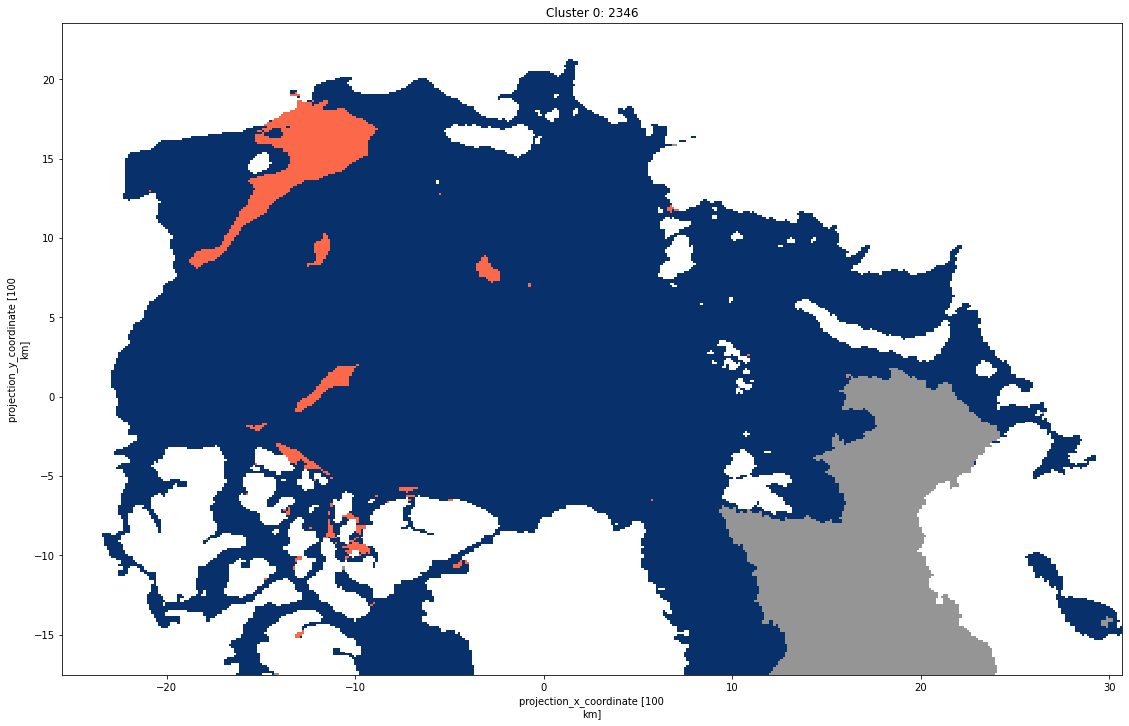

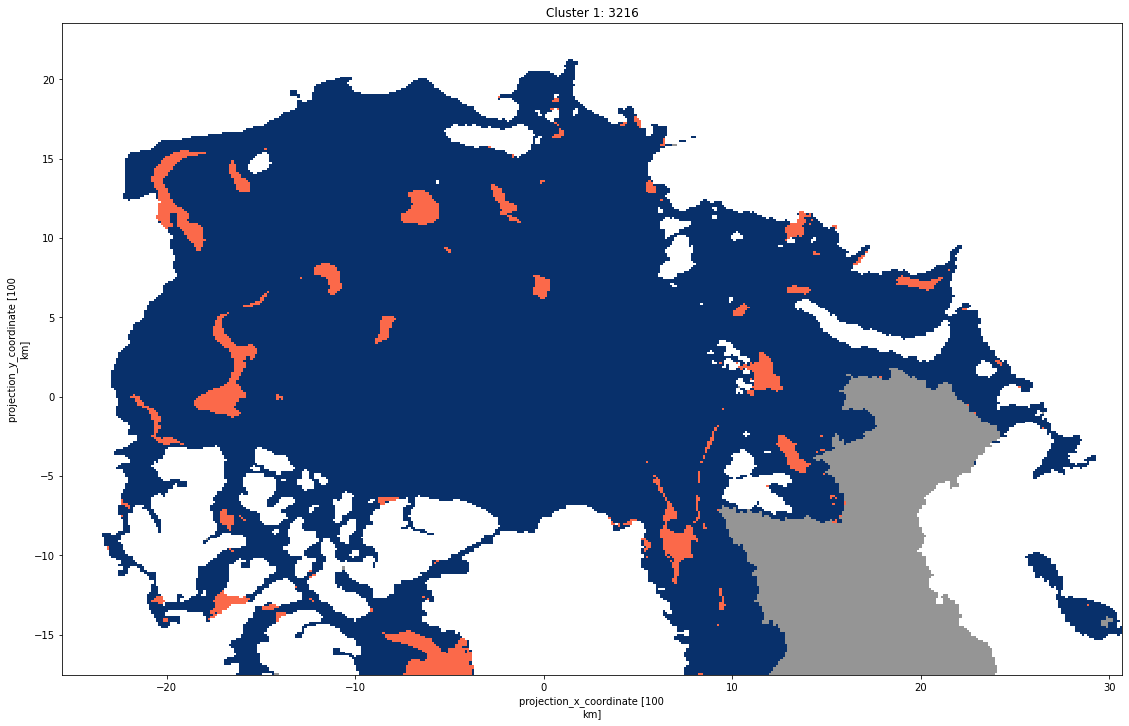

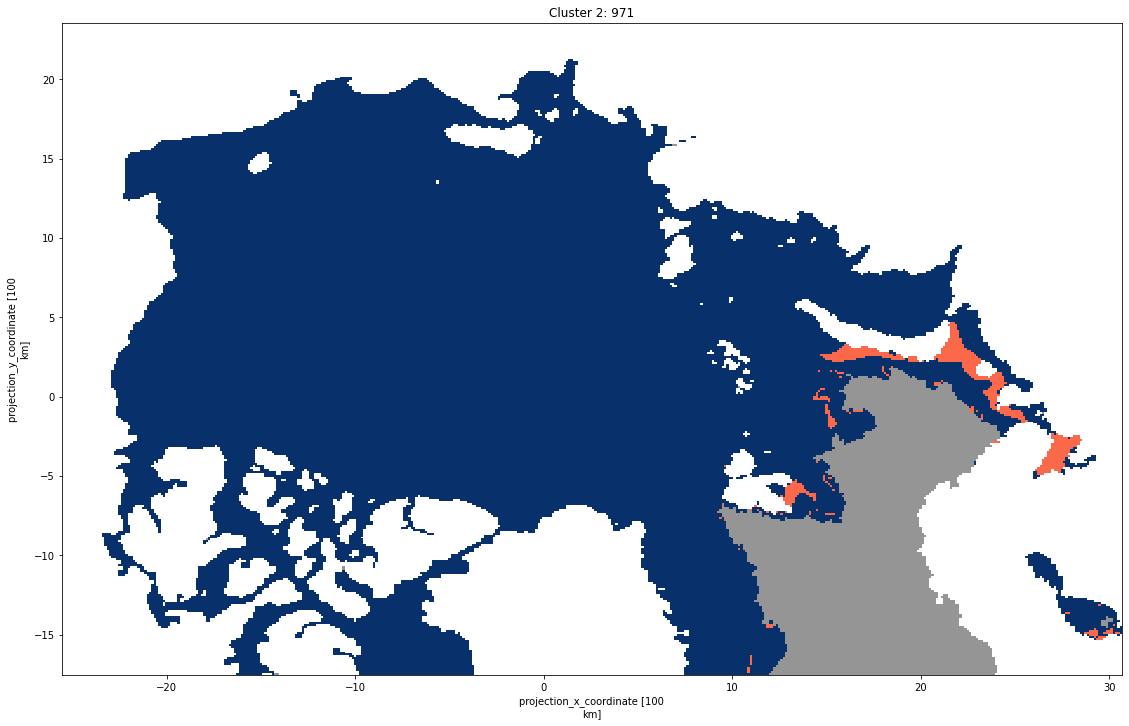

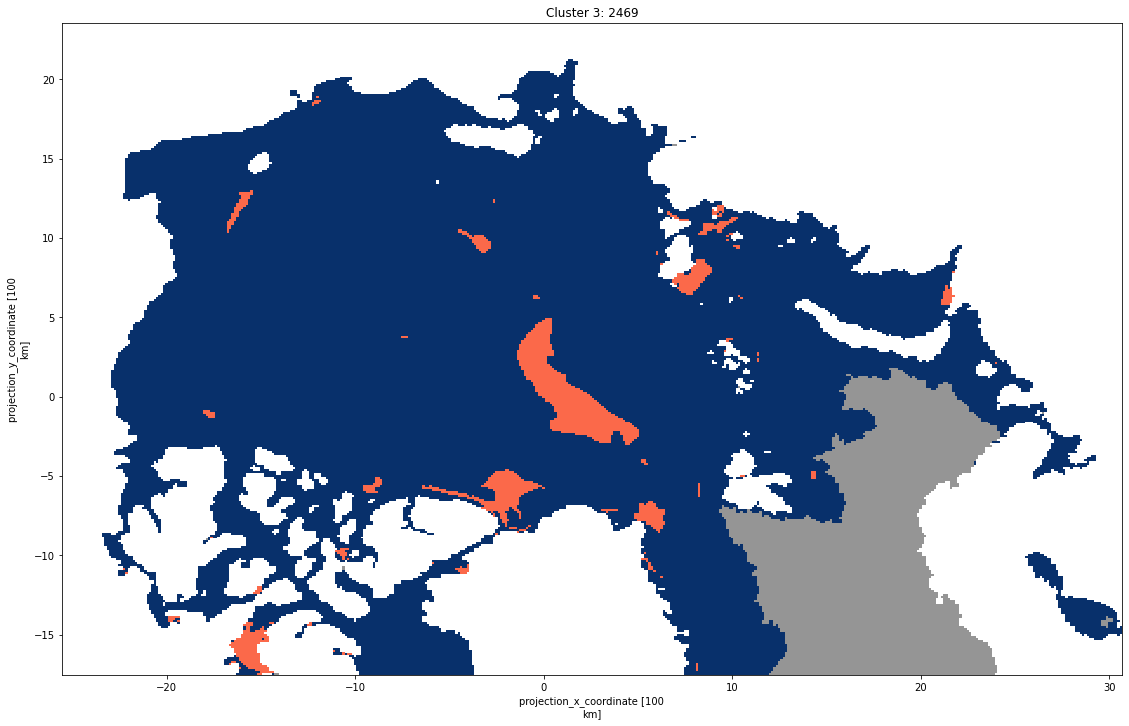

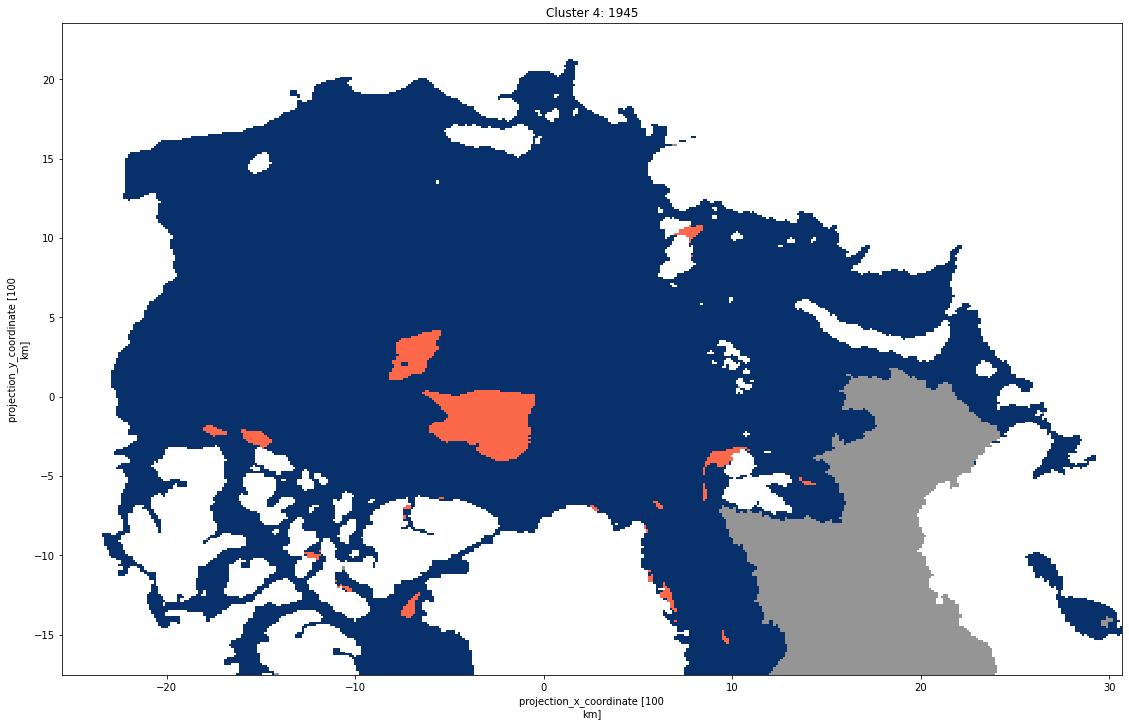

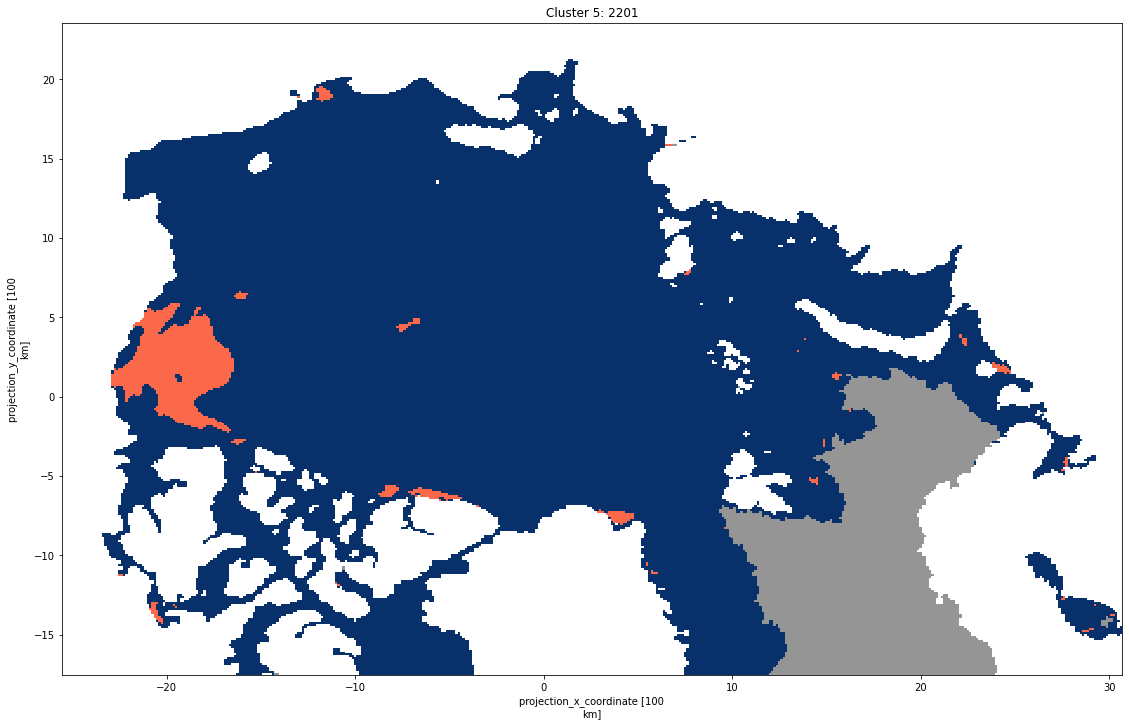

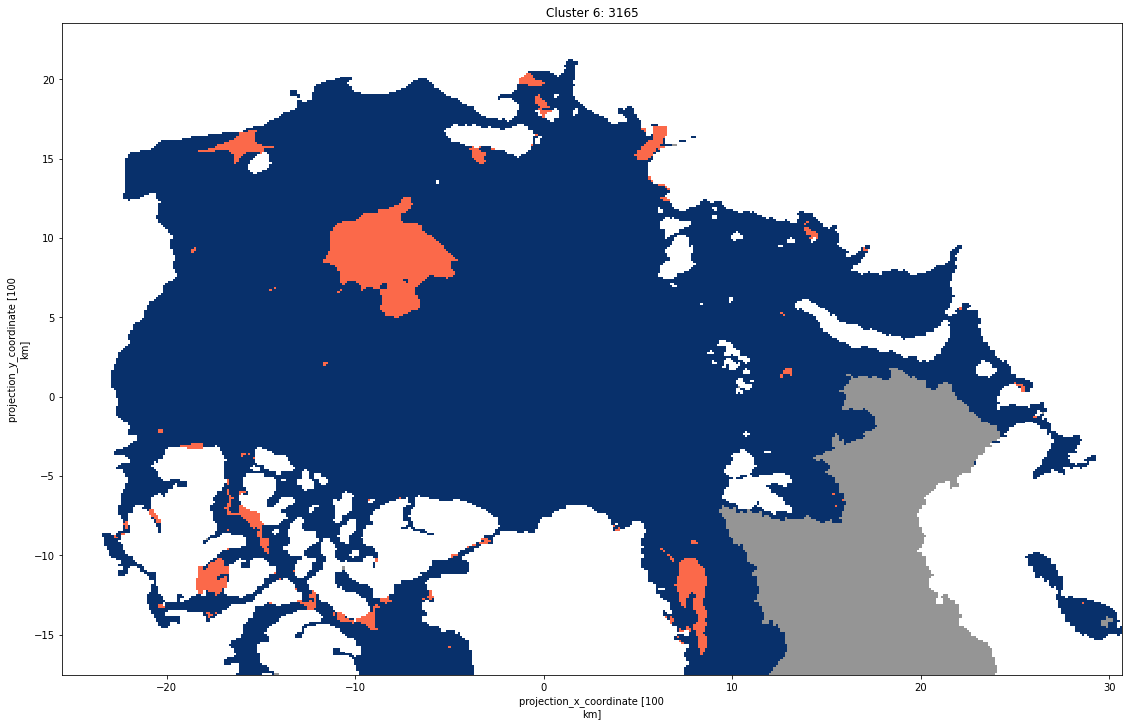

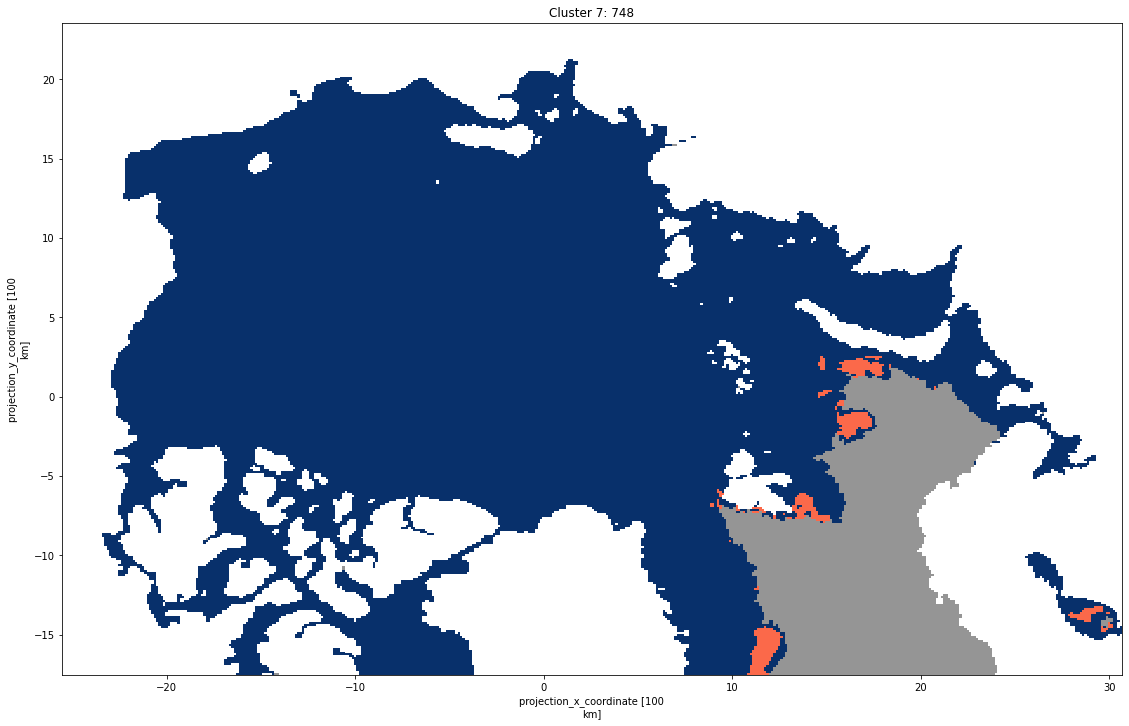

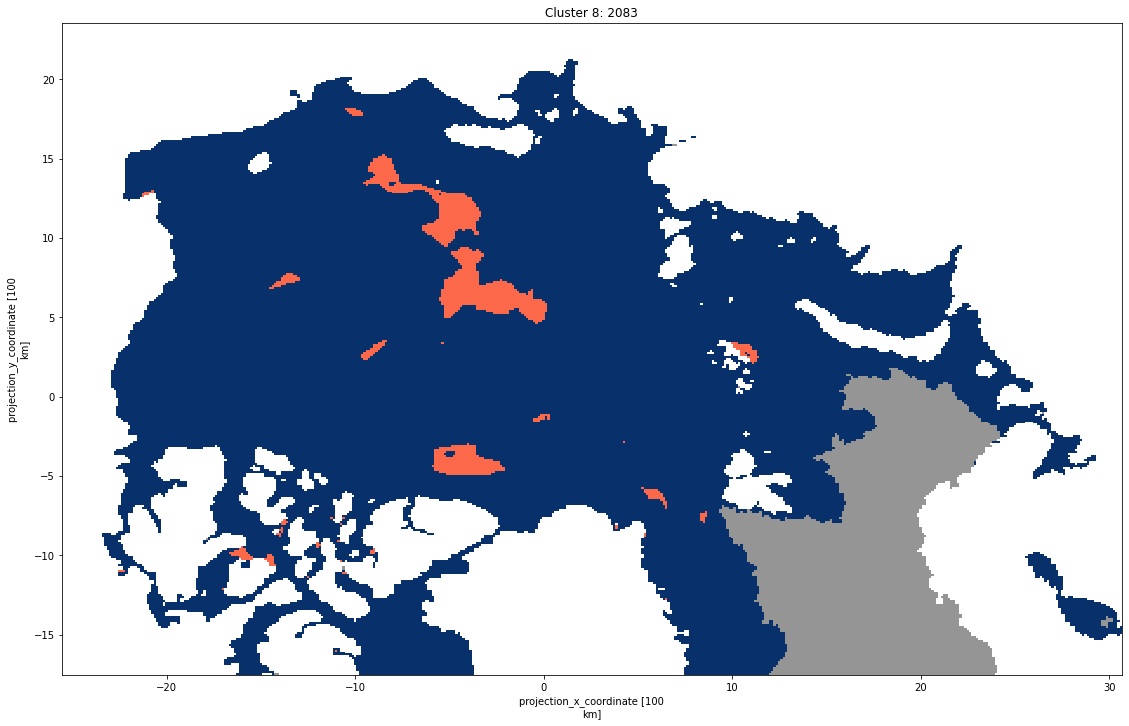

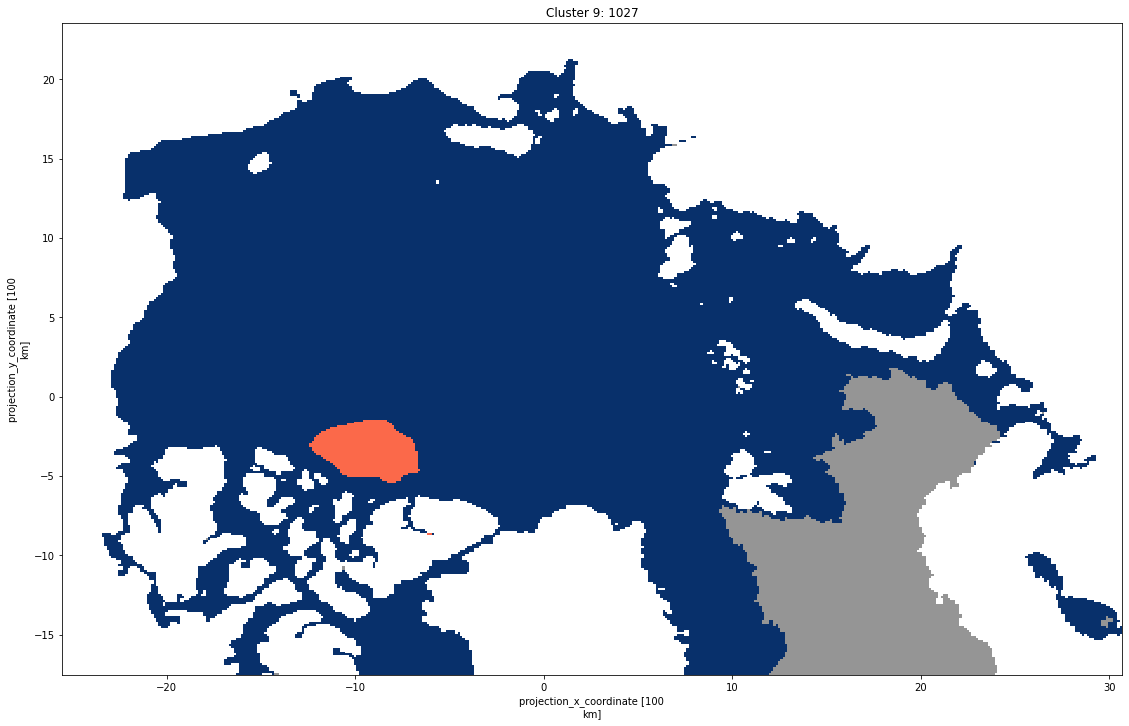

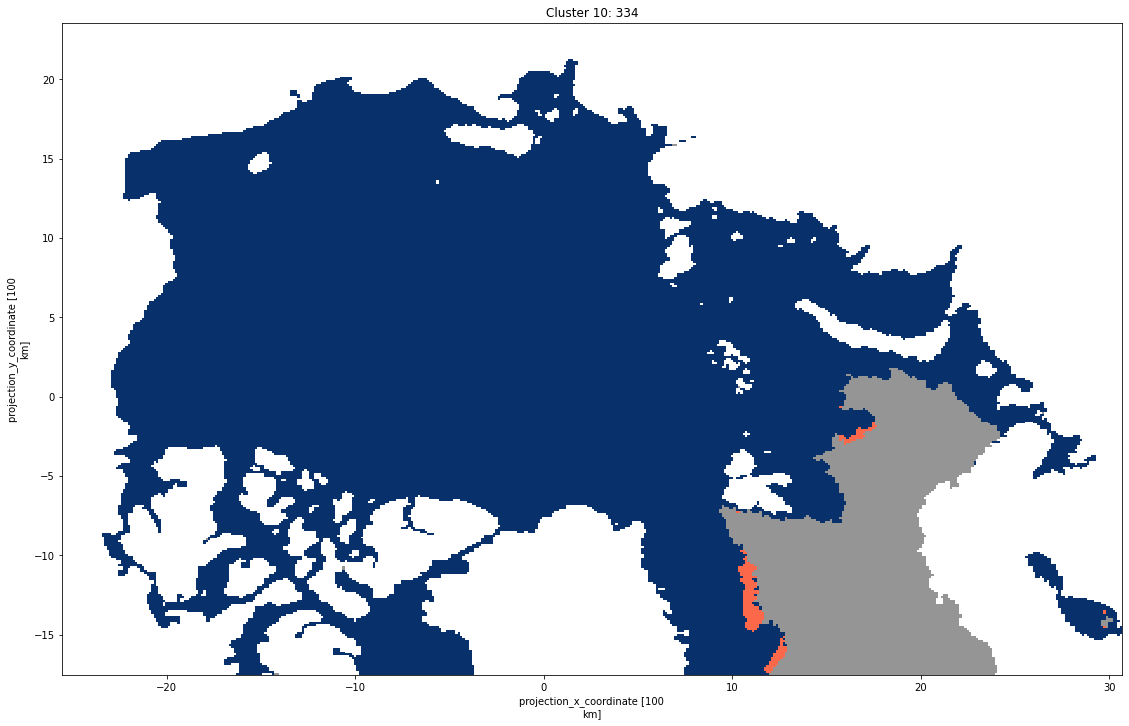

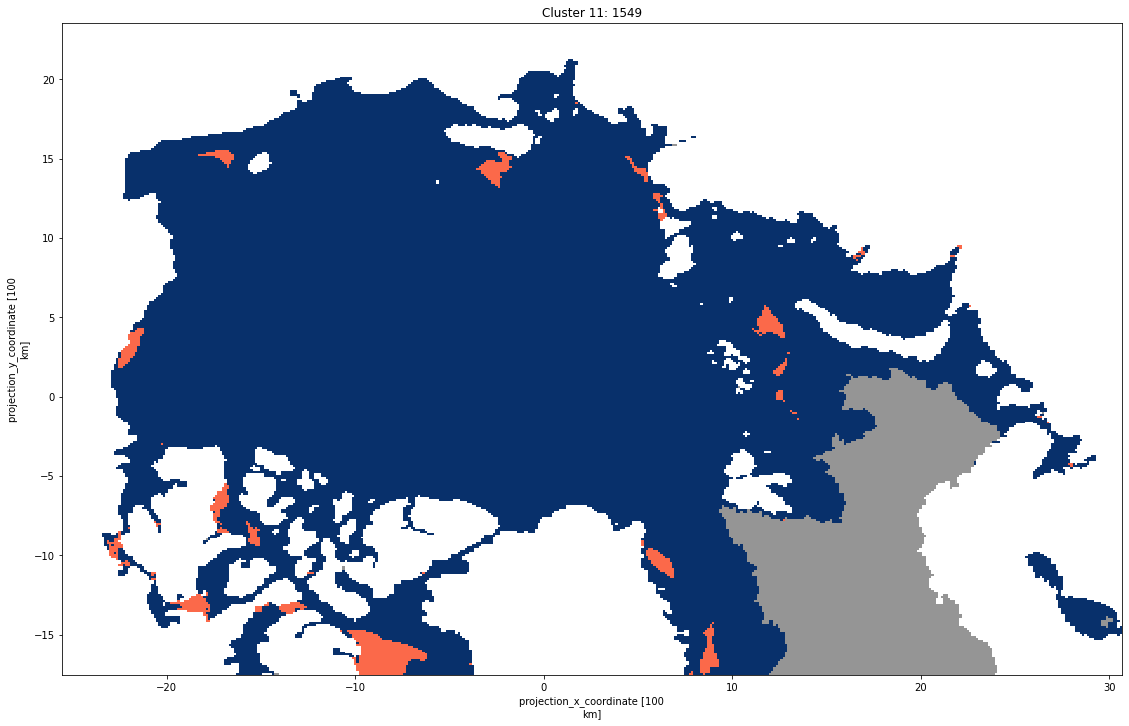

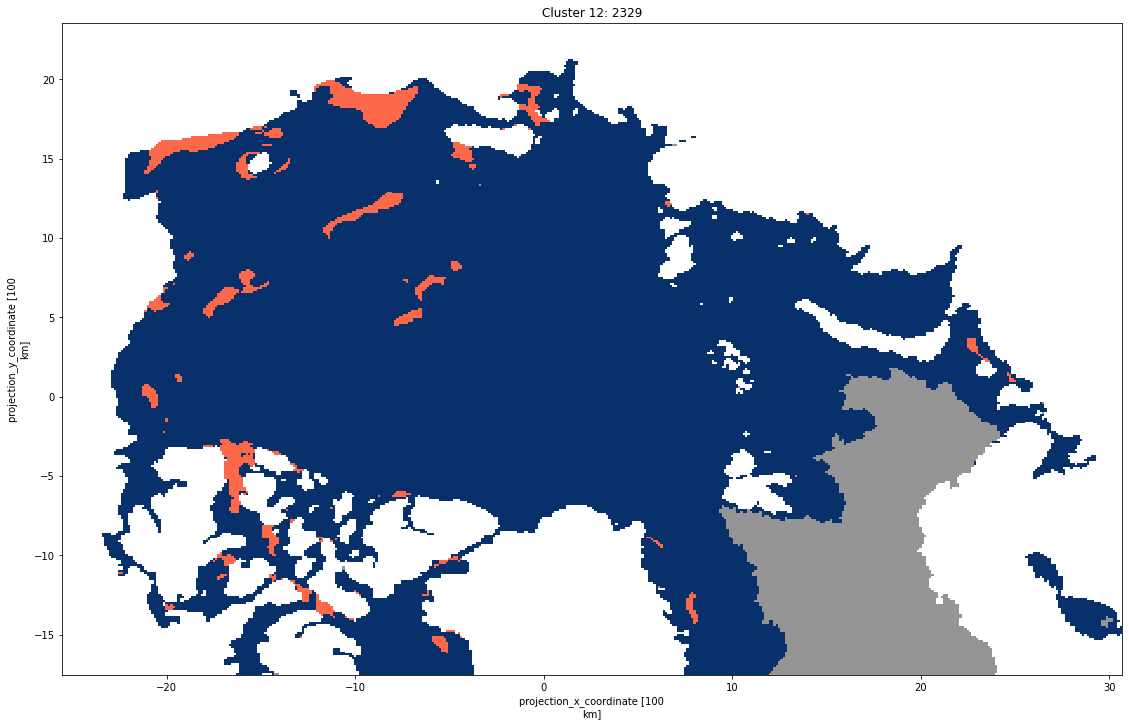

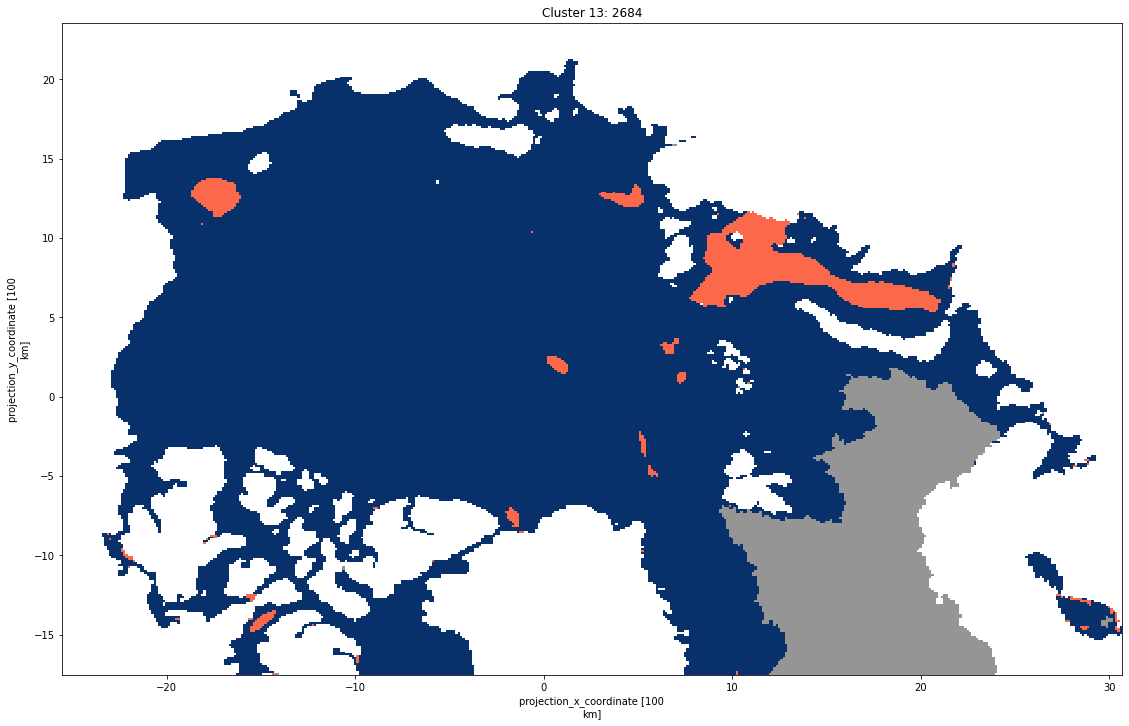

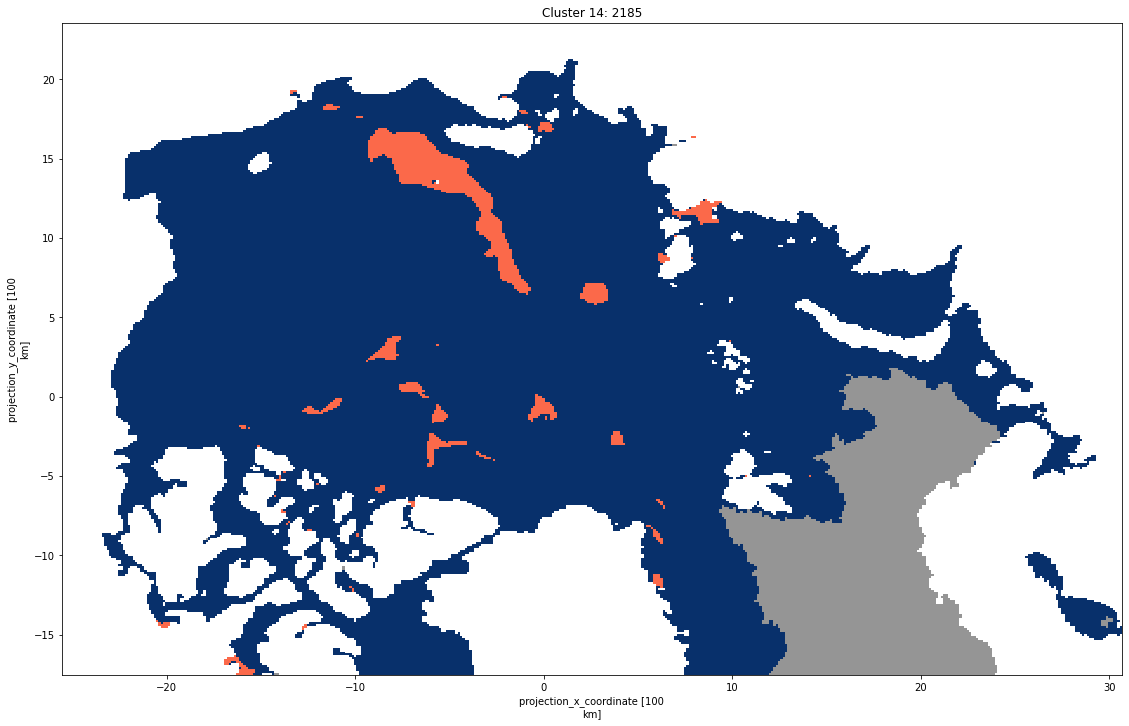

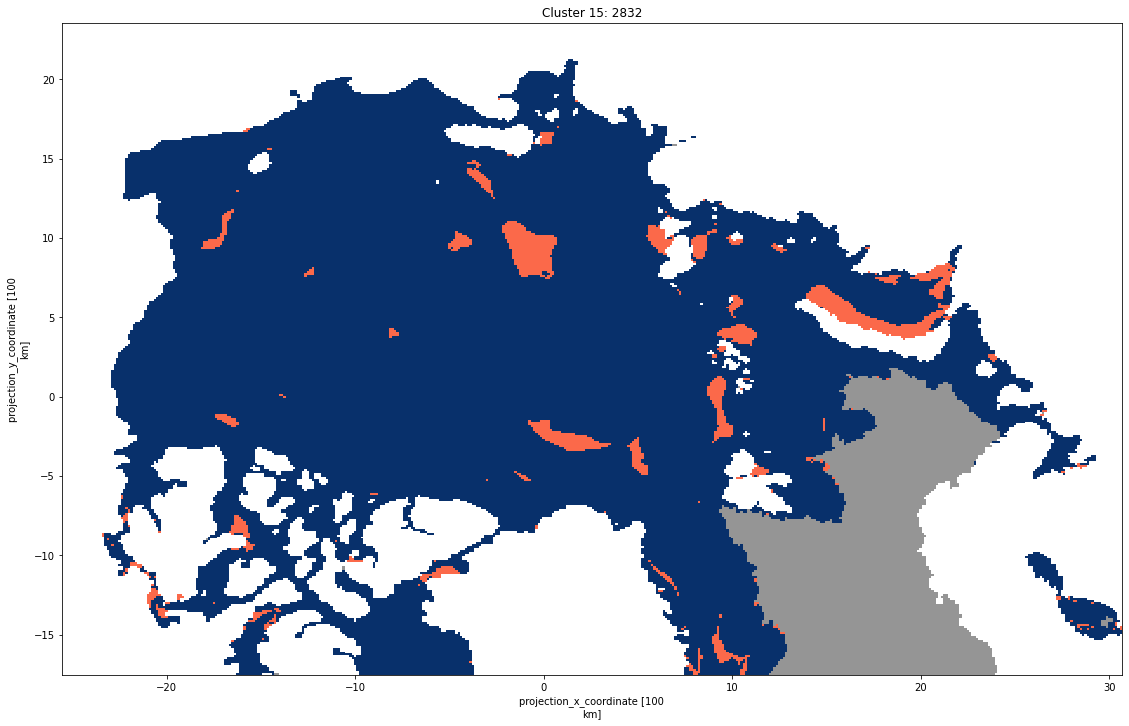

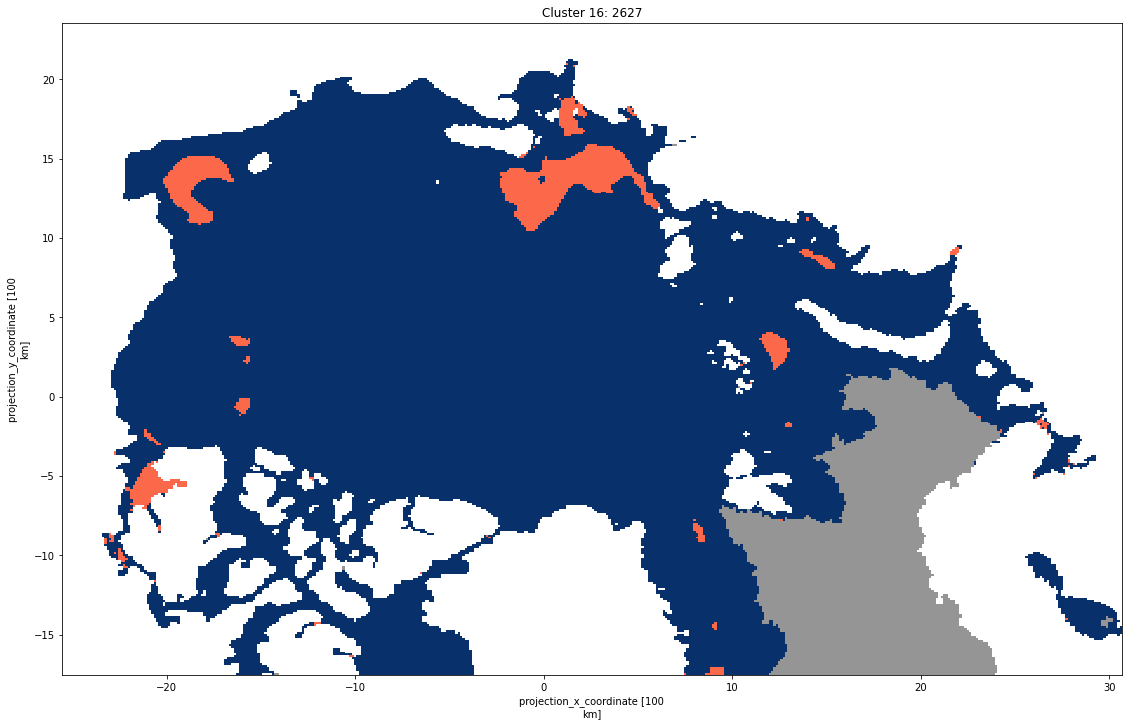

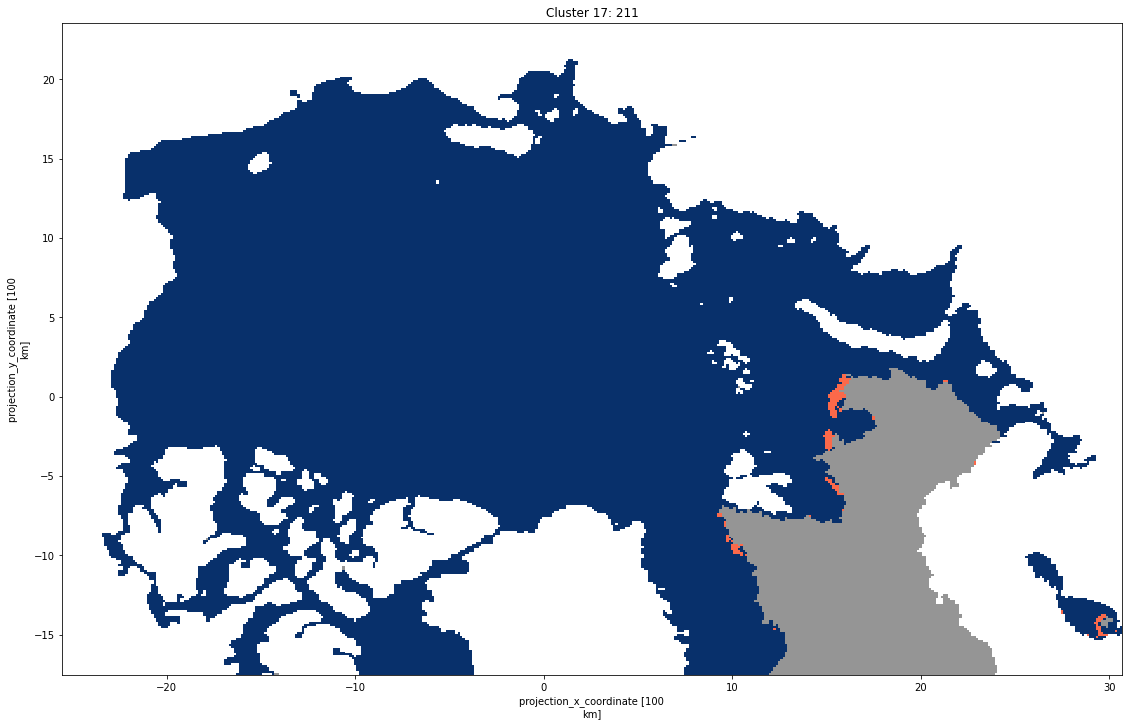

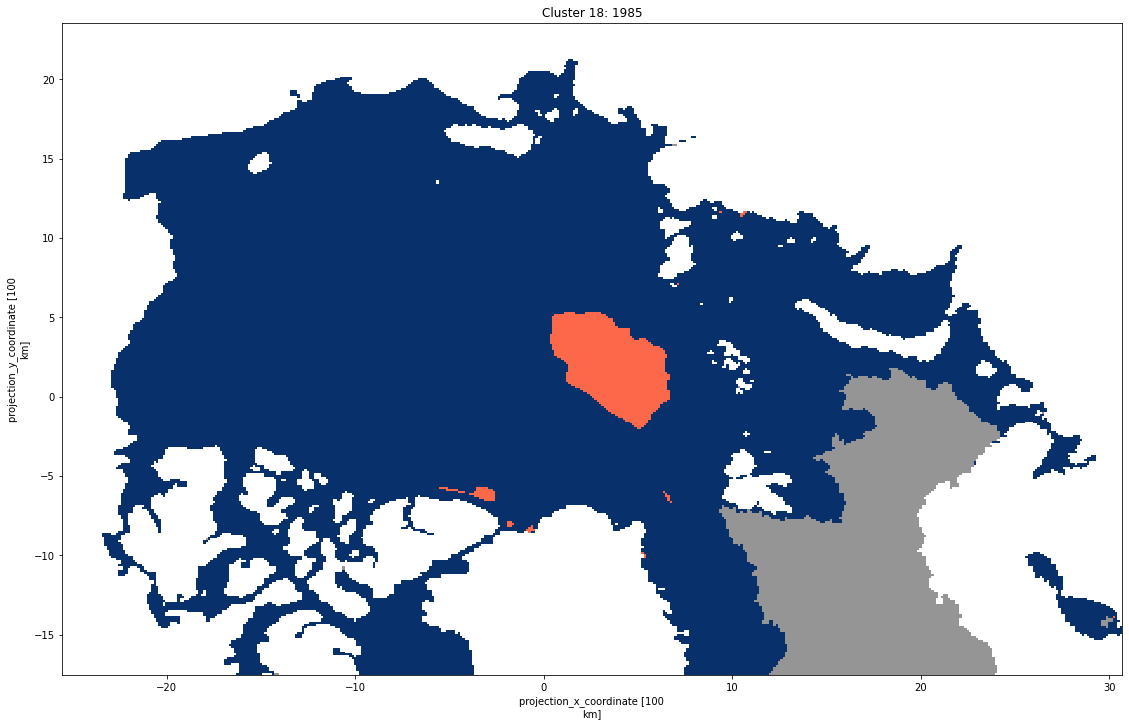

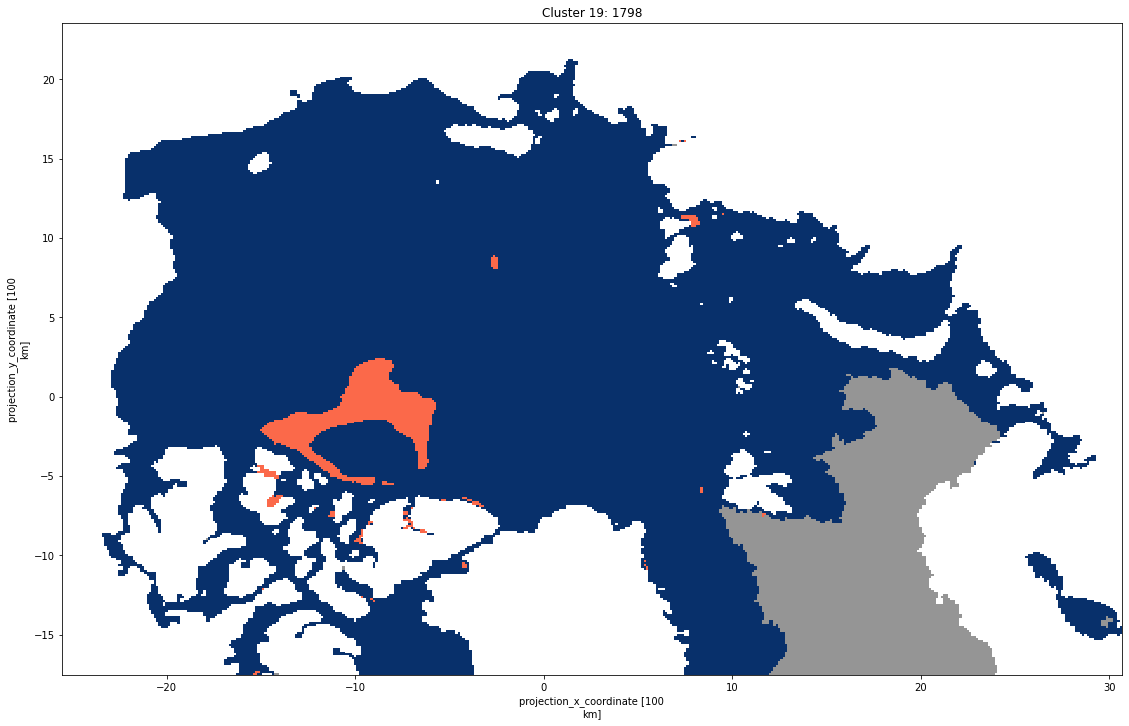

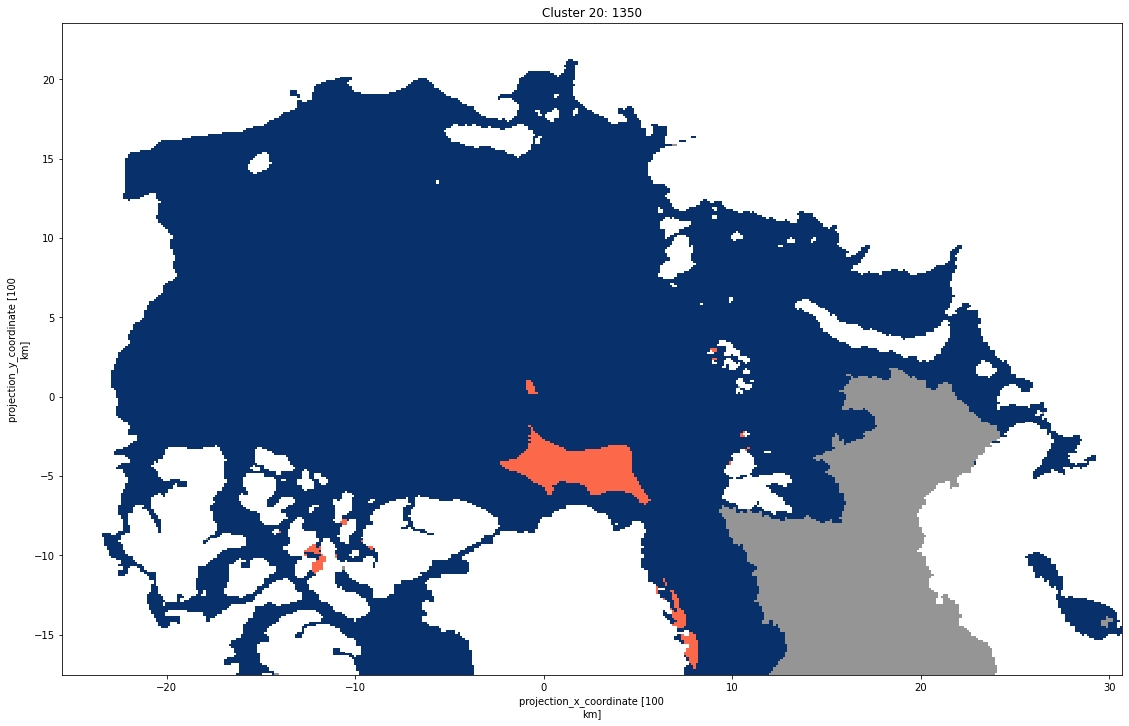

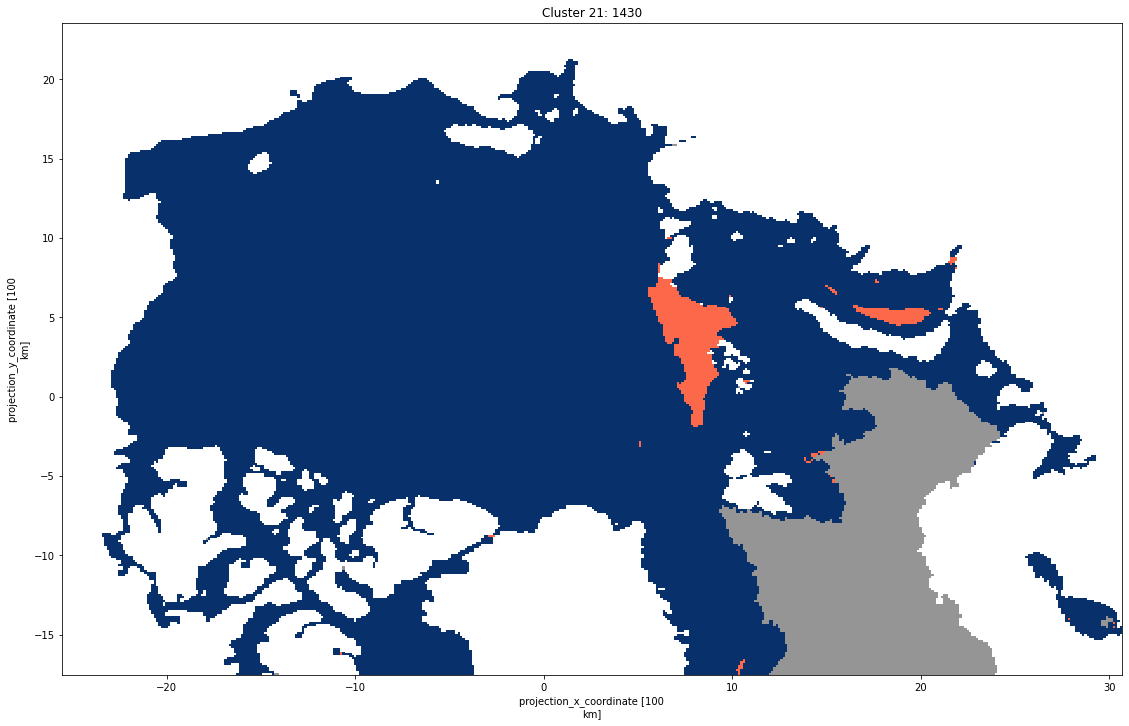

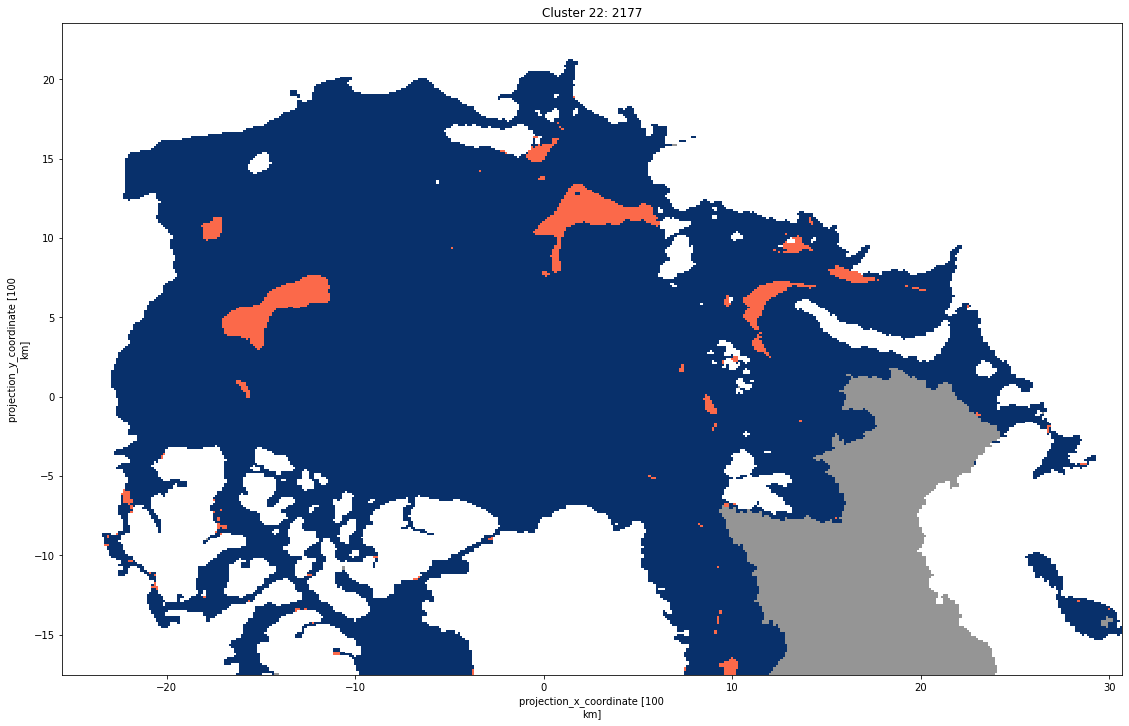

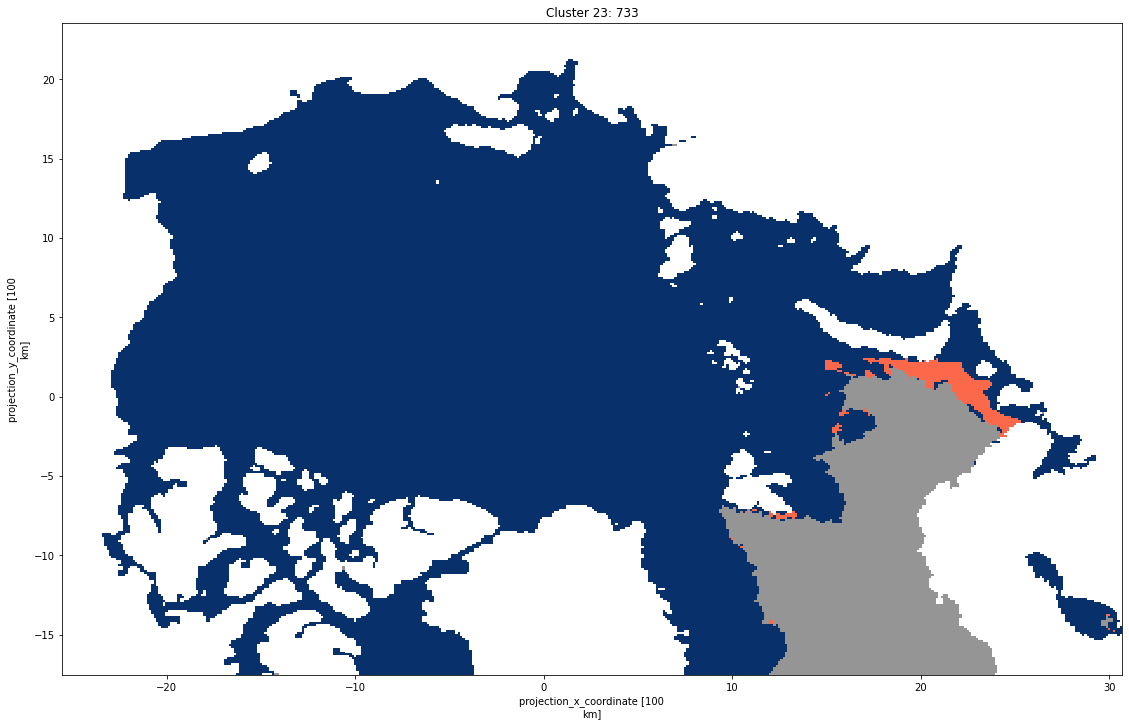

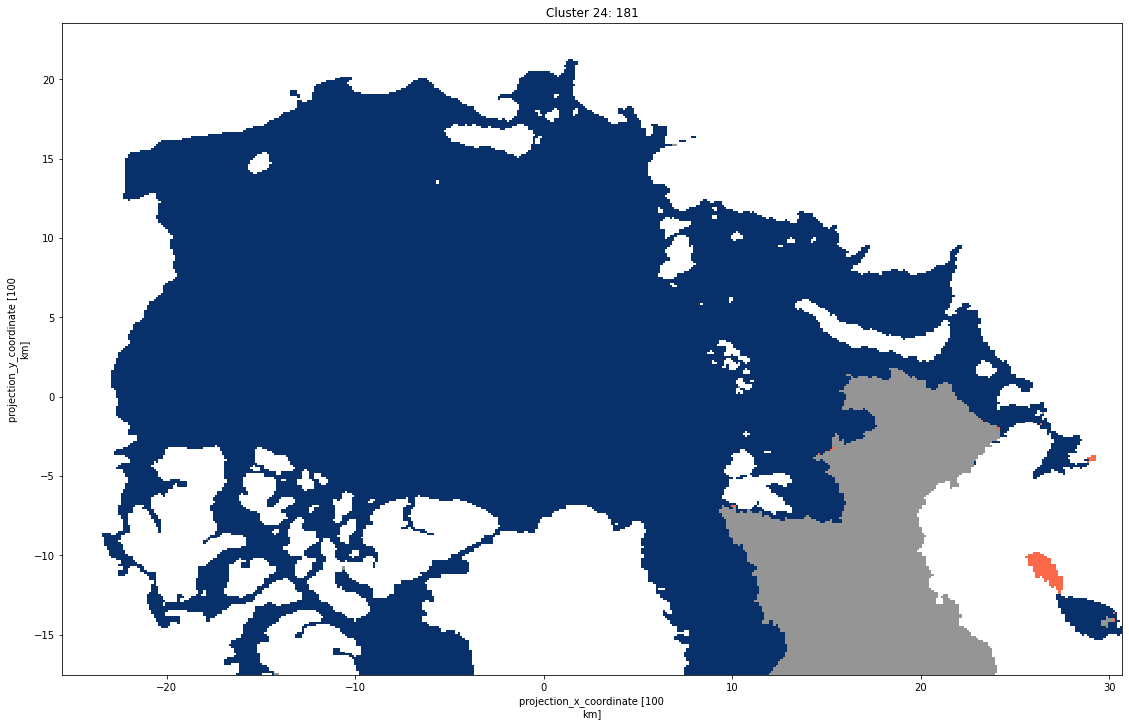

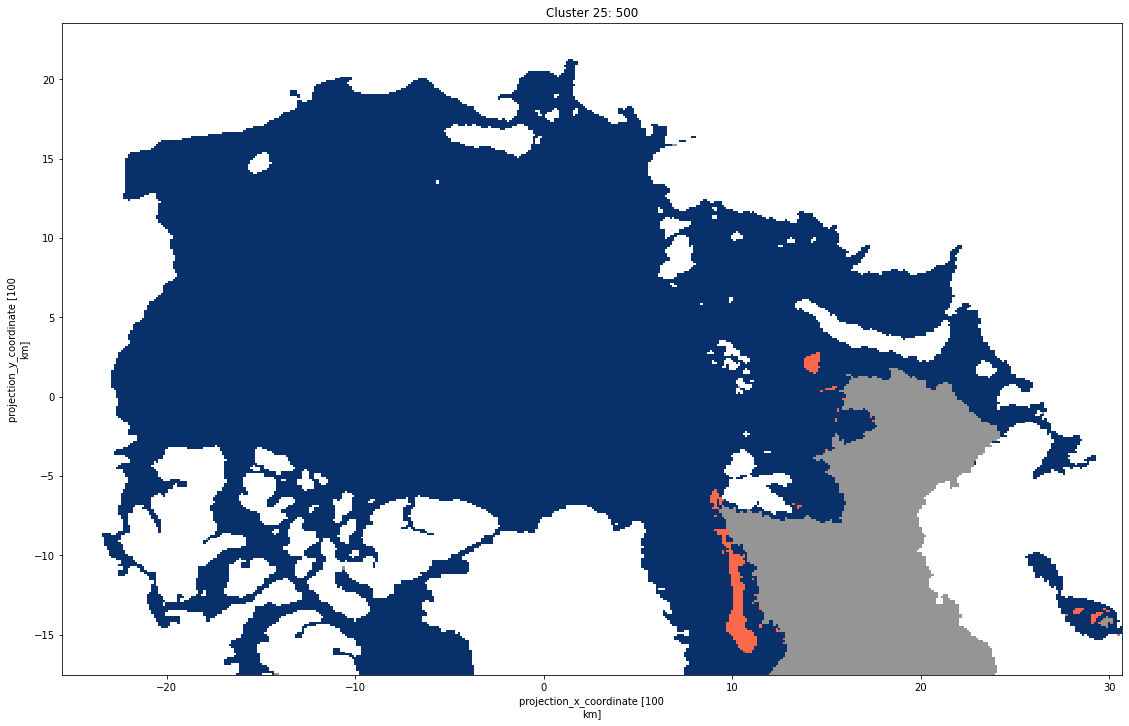

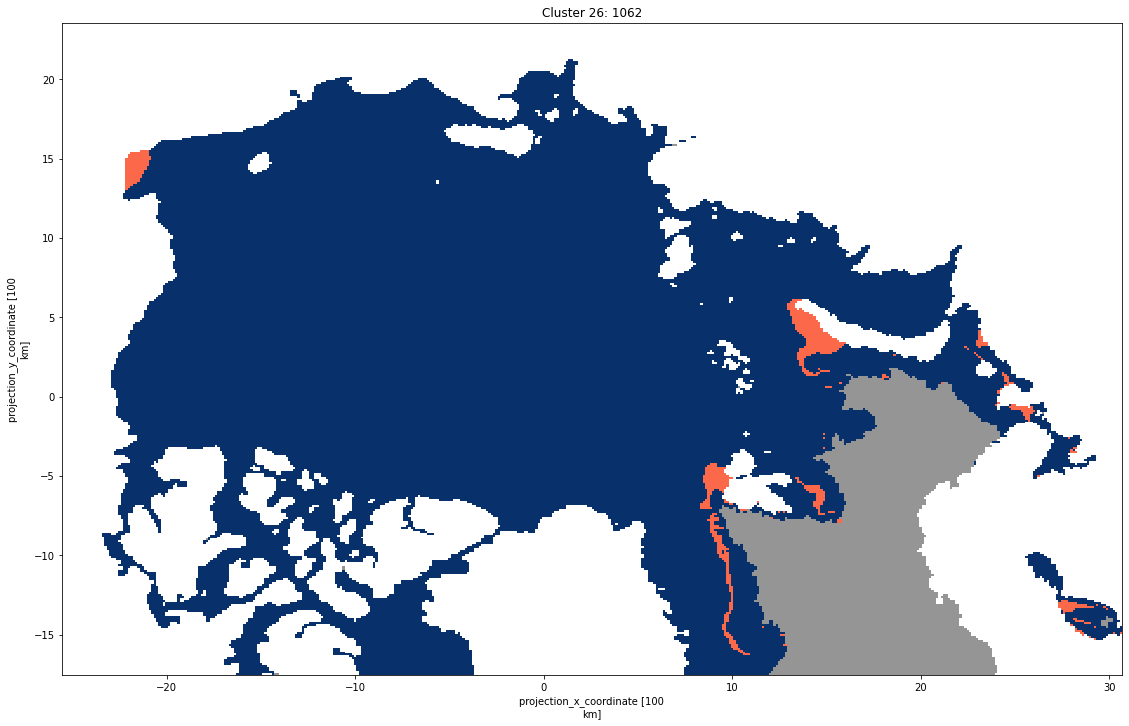

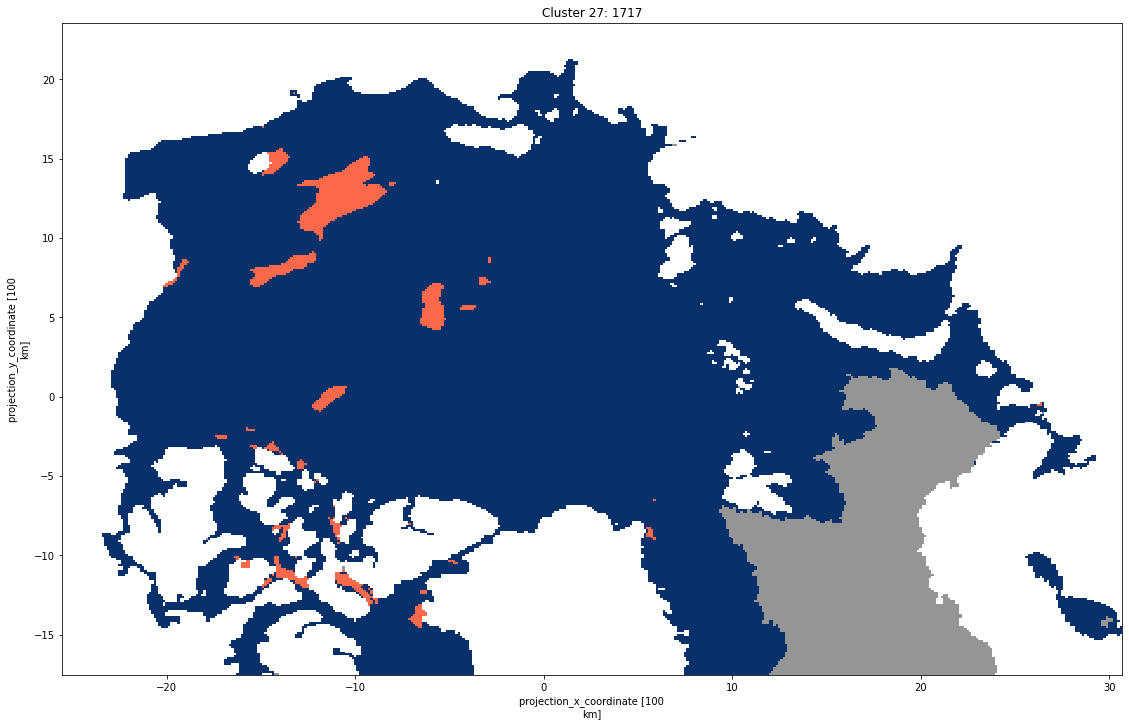

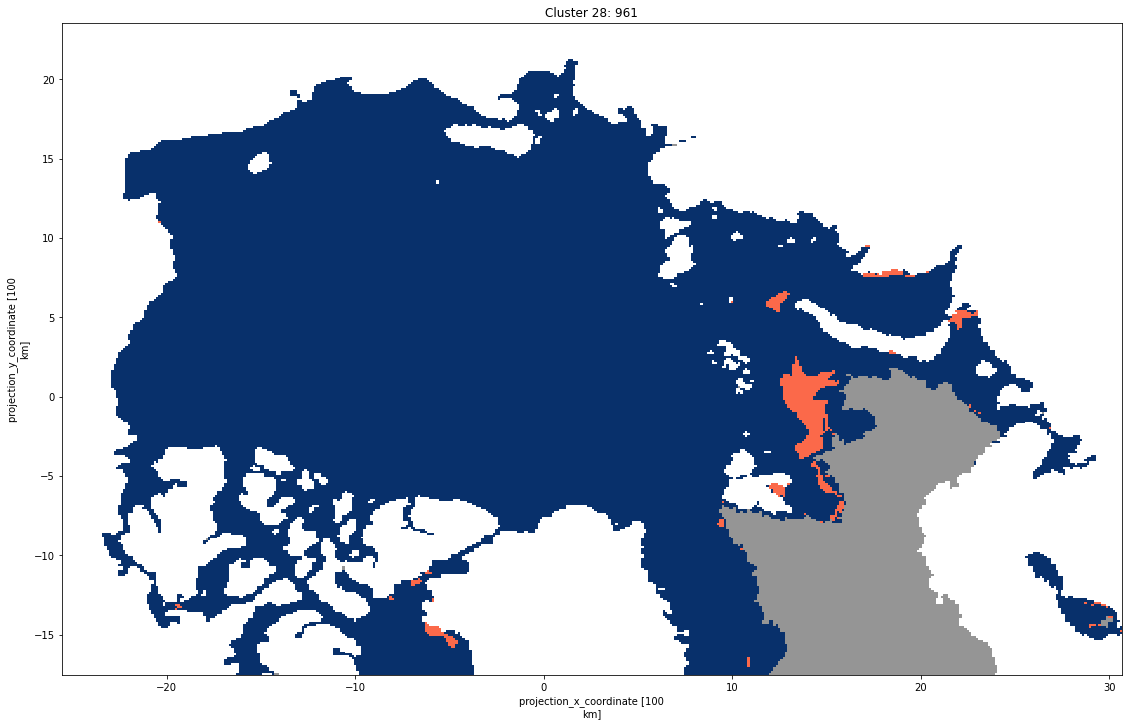

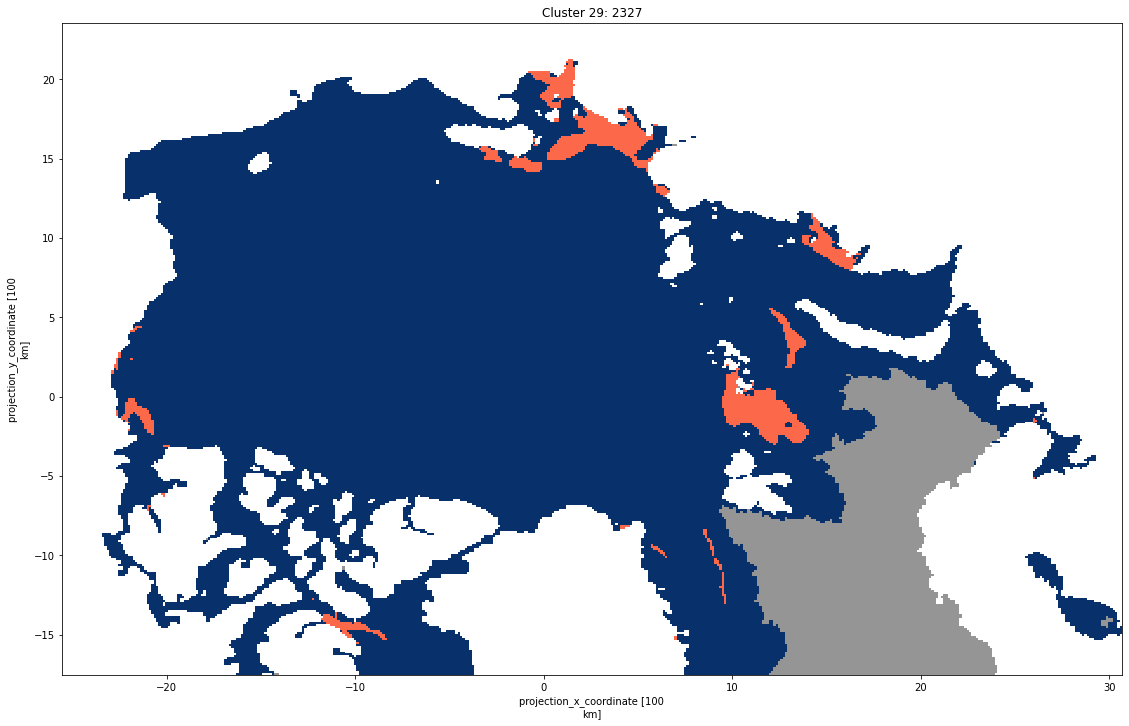

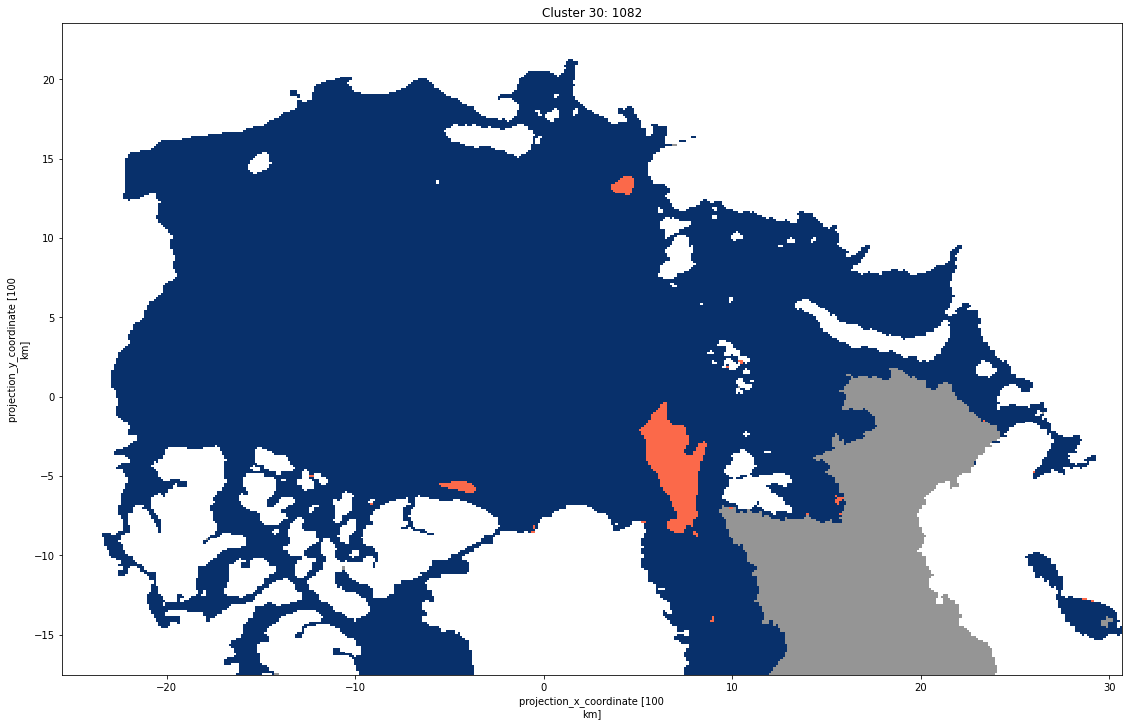

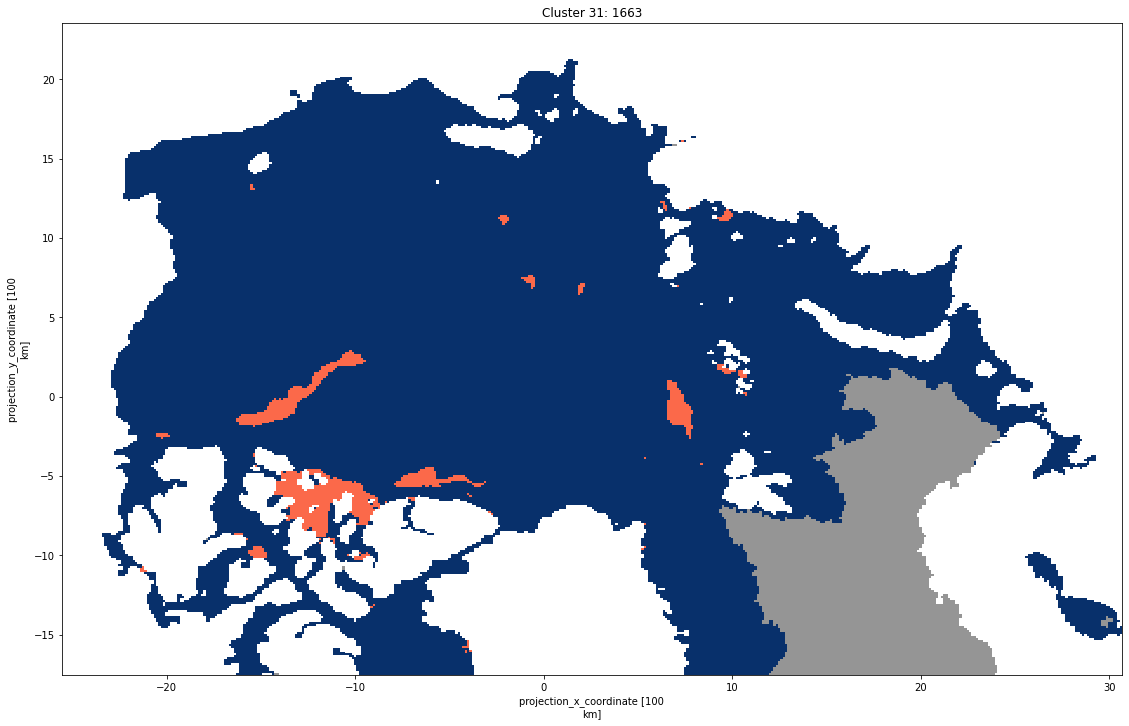

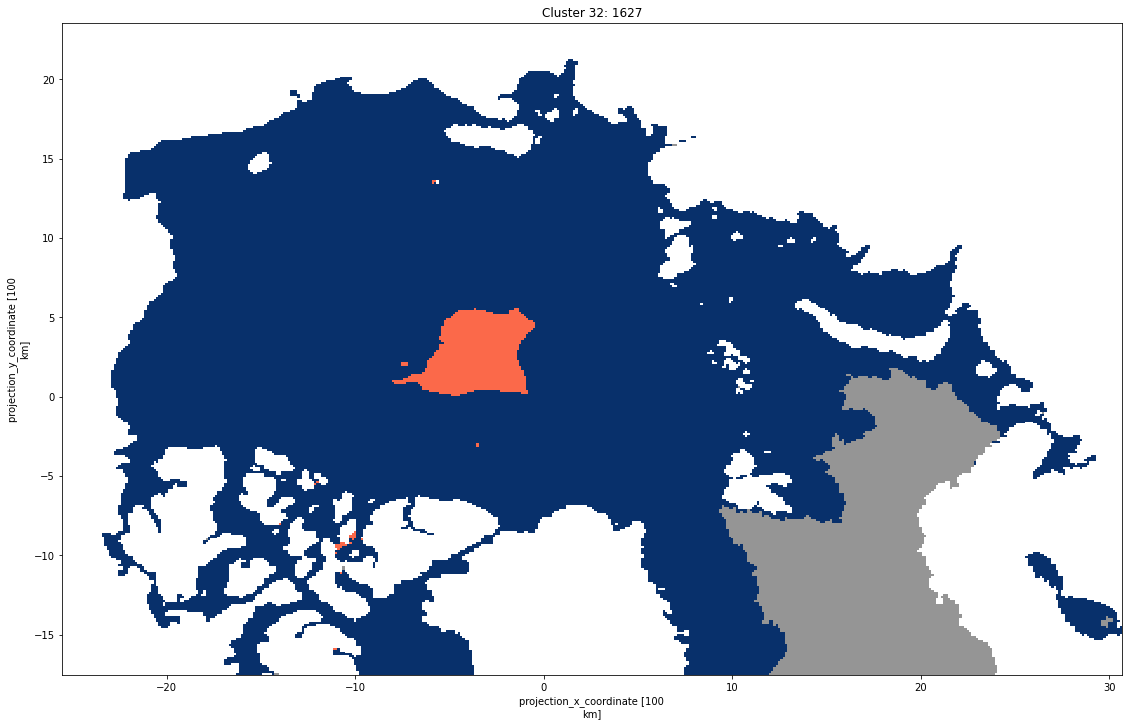

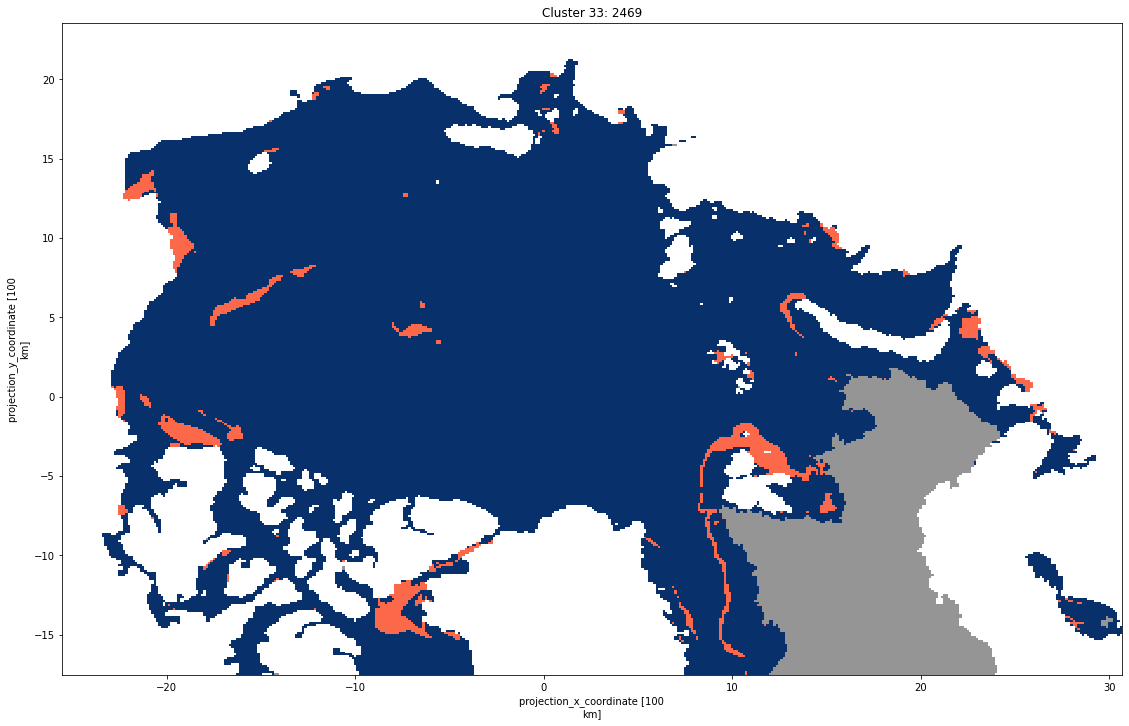

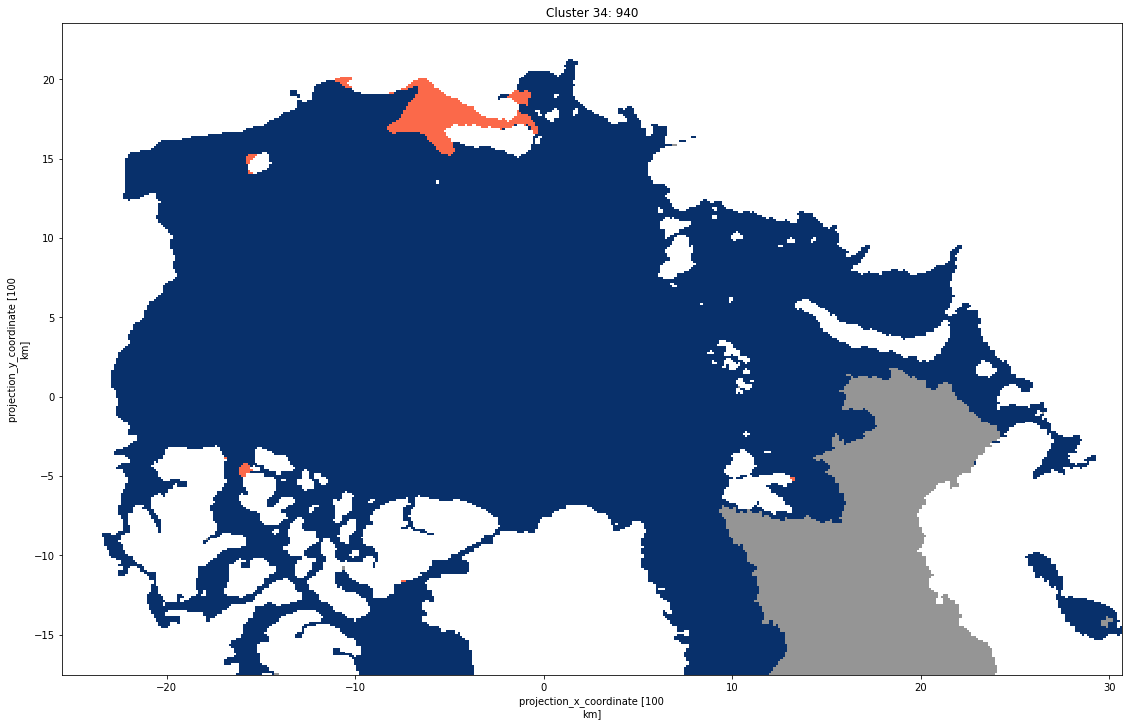

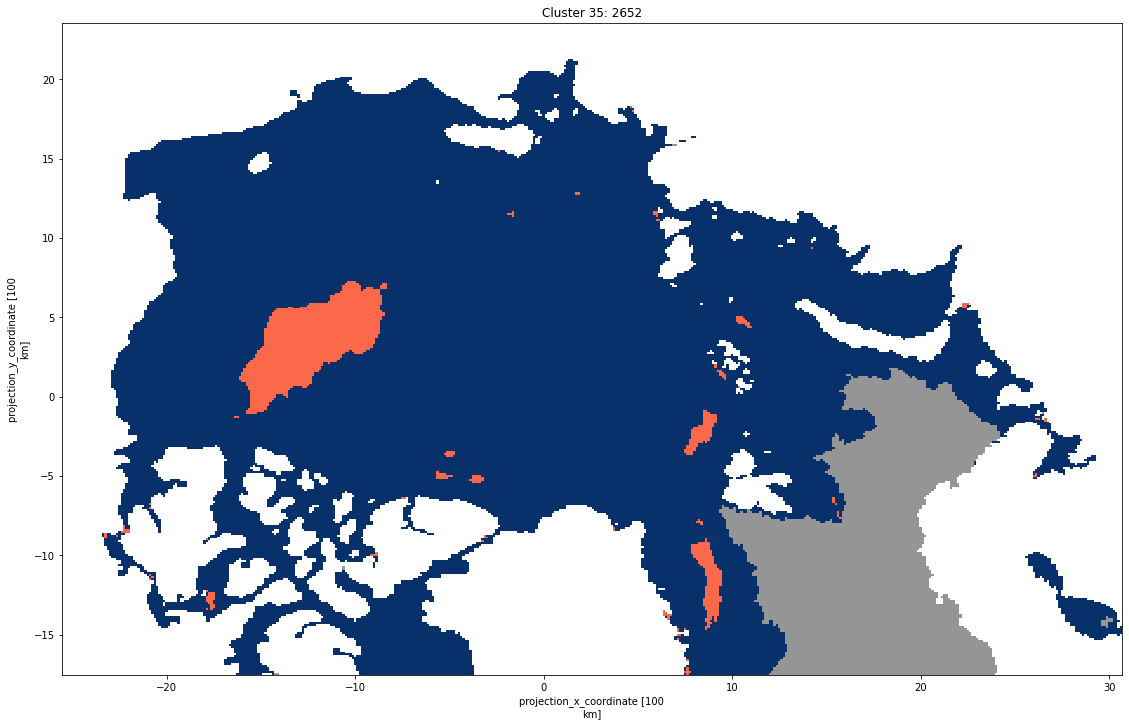

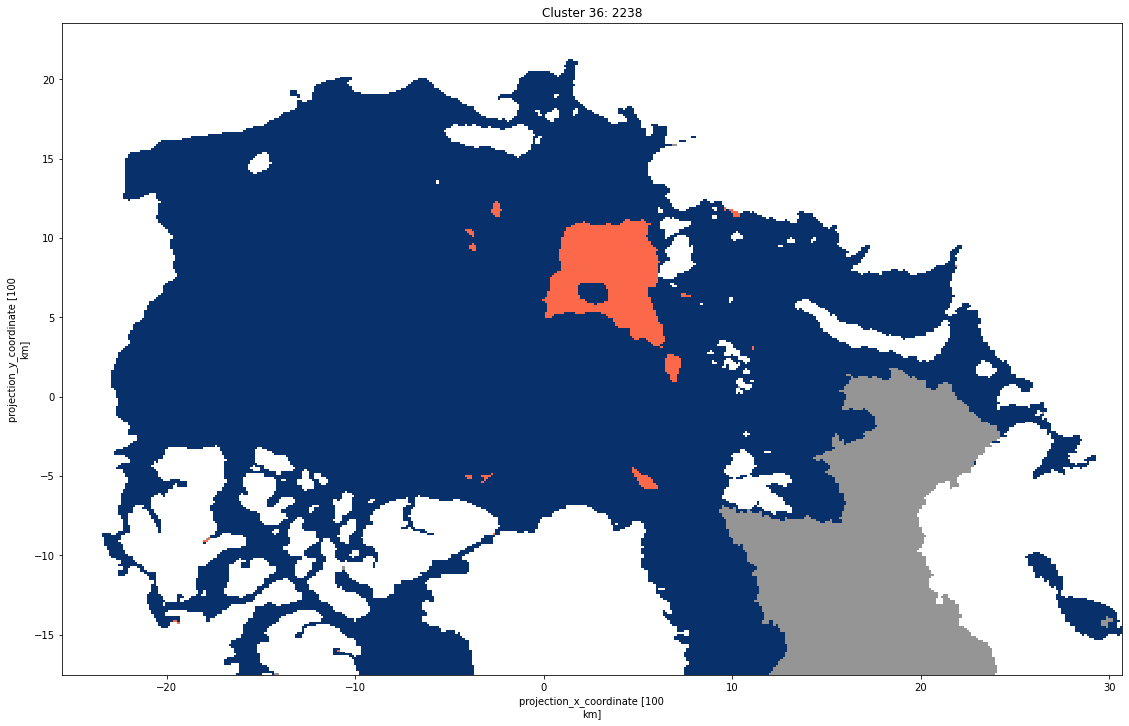

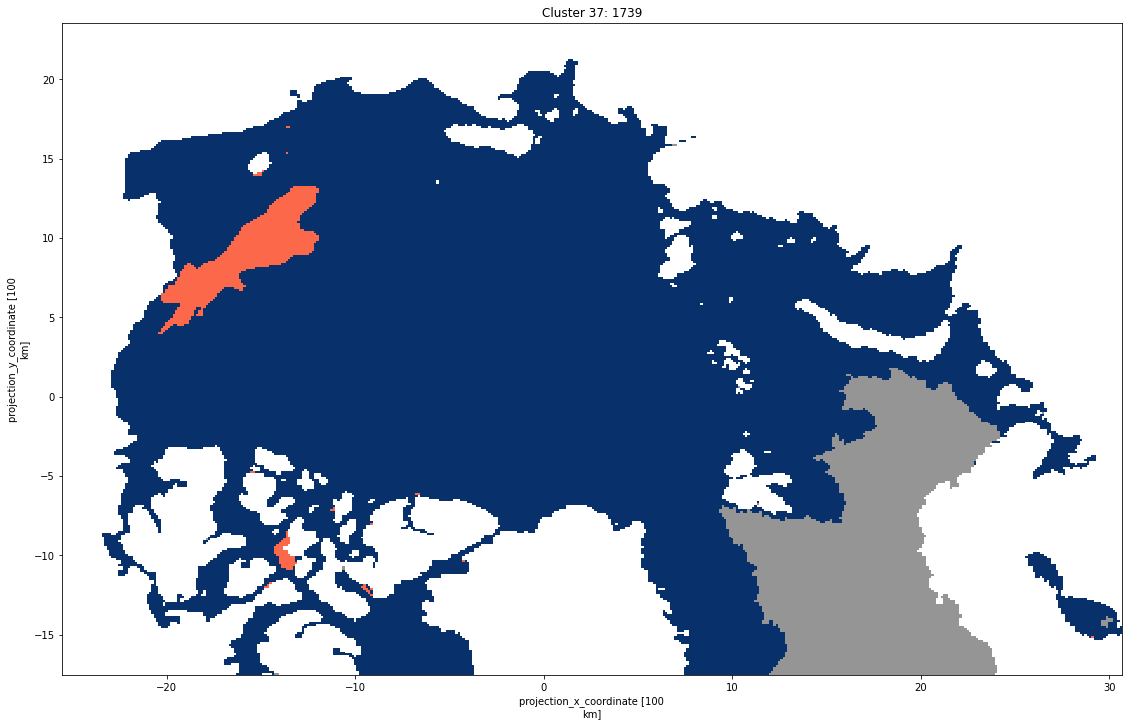

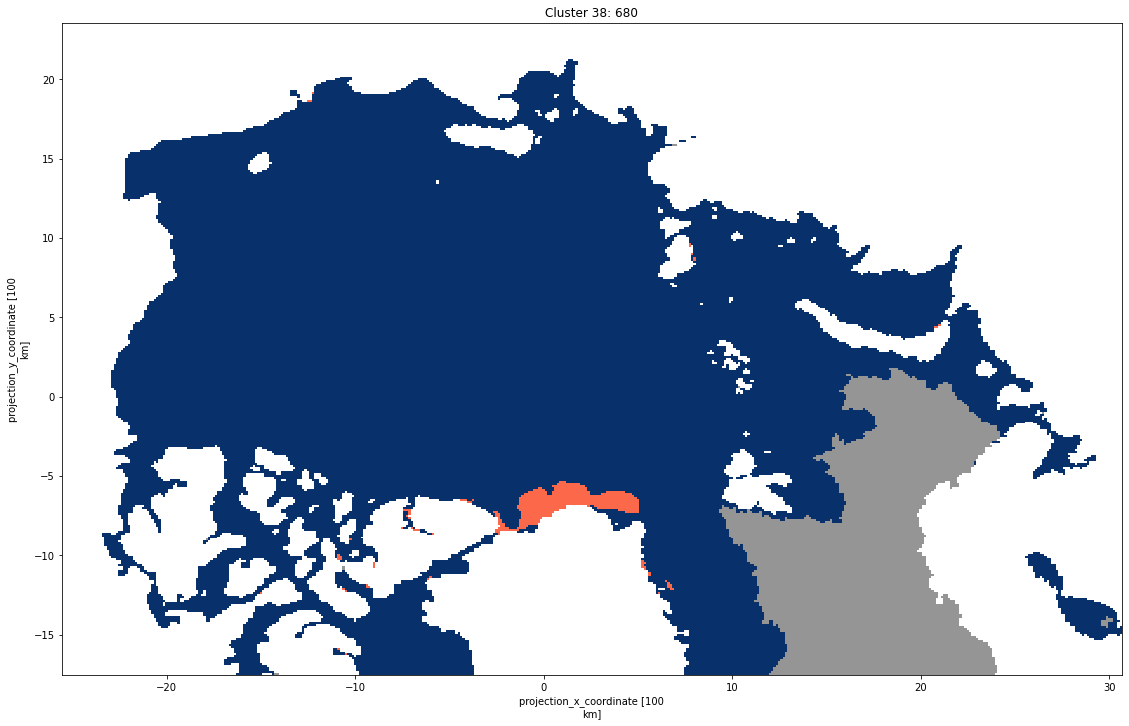

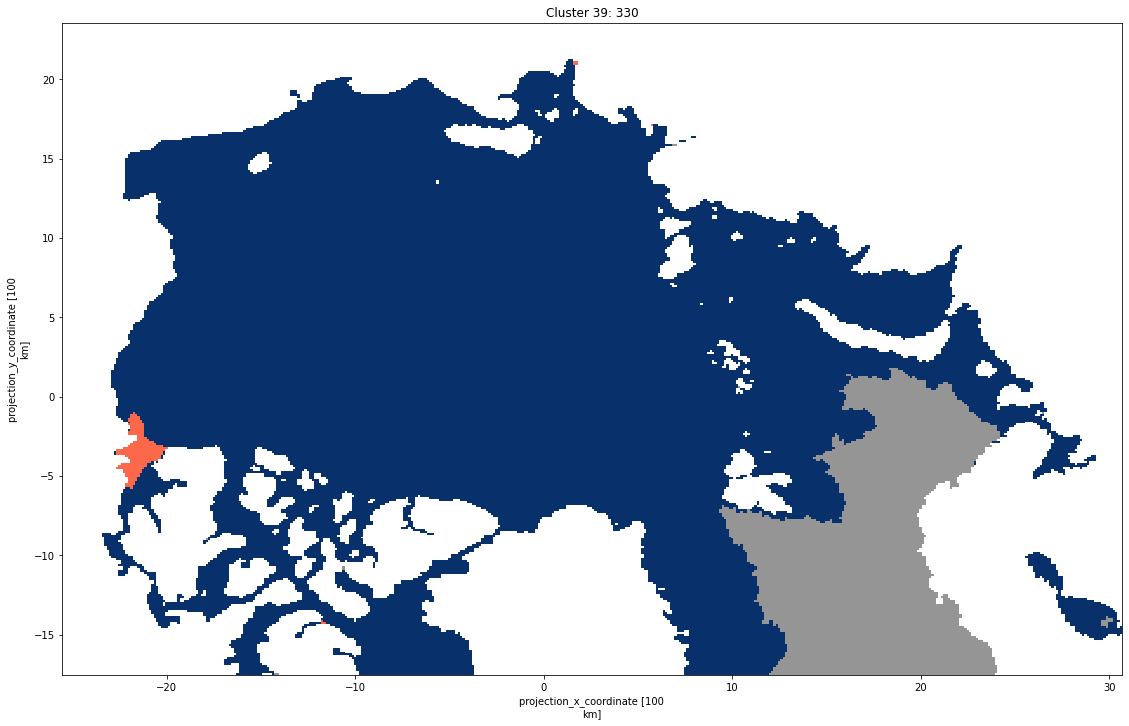

In [46]:
for ncl in range(n_clusters):
    plot_1cluster(ncl, km_xr)

In [146]:
# Selection a random point of a defined cluster

cluster_sel = 6
points_cl = np.where(km_xr==cluster_sel)

rdn = random.randint(0, len(points_cl[0]))
idx_pt = points_cl[0][rdn], points_cl[1][rdn]  # (y, x)

print(f'Point {rdn} of cluster {cluster_sel}: {idx_pt}')

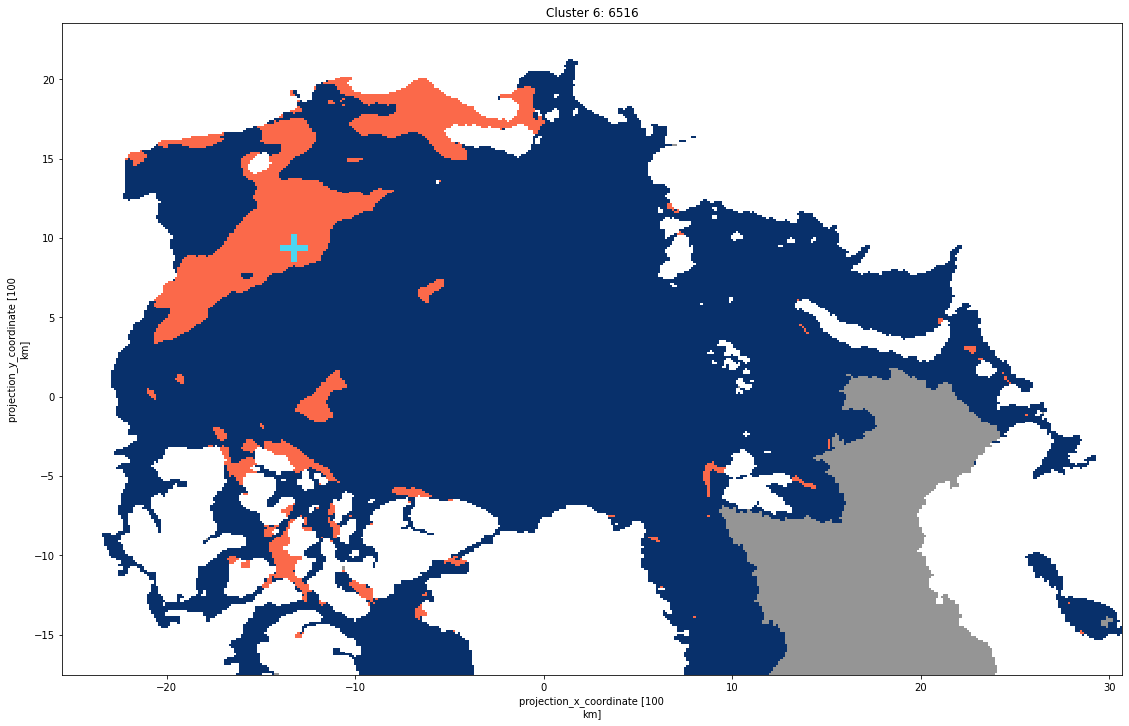

In [192]:
# visualize random point
plot_1cluster(cluster_sel, km_xr, points=[idx_pt])

In [205]:
# extract data for one random point

#bias_pt = Xeg[:, idx_pt[0], idx_pt[1]]
bias_pt = xr.DataArray(Xeg[:, idx_pt[0], idx_pt[1]], coords={'time':Xeg['time']}, dims=['time'])

In [209]:
# select all points in cluster
#points_cl
#bias_all = np.zeros((Xeg.shape[0], len(points_cl[0])))

# too slow
# for idx, pt in enumerate(zip(points_cl[0], points_cl[1])):
#    bias_all[:, idx] = Xeg[:, pt[0], pt[1]]

bias_pt.plot()

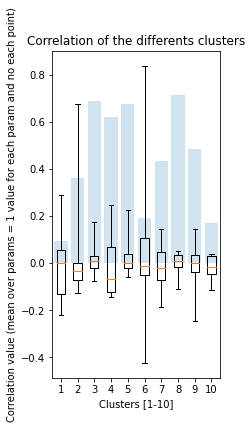

In [343]:
def plot_stats_all_clusters(y_kmeans, corr, fullmap, n_clusters):
    """ Plot each cluster stats + cluster sizes in background
    """
    # Input : (cluster, correlations)
    n_param = corr.shape[1]
    cors_clust = [None for i in range(n_clusters)]
    cor_mean = np.empty([n_param, n_clusters])
    for c in range(n_clusters):
        cors_clust[c] = corr[np.where(y_kmeans == c)]
        cor_mean[:, c] = np.mean(cors_clust[c], axis=0)

    # Cluster sizes
    sizes = np.empty(n_clusters)
    for cluster in range(n_clusters):
        sizes[cluster] = np.count_nonzero(np.array(fullmap) == cluster) / 15000
        
    
    # Plots
    fig, ax = plt.subplots(figsize=(int(0.3*n_clusters),6))
    
    plt.bar(x=np.arange(1, n_clusters+1), height=sizes, alpha=0.2)
    
    plt.boxplot(cor_mean, whis=[0, 100])
    plt.xlabel(f'Clusters [1-{n_clusters}]')
    plt.ylabel('Correlation value (mean over params = 1 value for each param and no each point)')
    plt.title(f'Correlation of the differents clusters')
    

plot_stats_all_clusters(y_kmeans, corr_nonan, km_xr, n_clusters)

In [332]:
def plot_stats_1_cluster(y_kmeans, corr, cluster, params, savefig=False, showfig=True, odir=''):
    """ Plot the stats for 1 cluster
    """
    cor_mean = corr[np.where(y_kmeans == cluster)]

    # Plots
    fig, ax = plt.subplots(figsize=(10, 6))
    
    plt.boxplot(cor_mean, whis=[0, 100])

    plt.hlines(y=0, xmin=0+1, xmax=len(params), ls='--', color='grey', zorder=-100)
    
    plt.xticks(range(1, len(params)+1), params, rotation= -25)
    plt.xlabel('Parameters')
    plt.ylabel('Correlation value')
    plt.title(f'Correlation cluster {cluster}')
     
    if savefig:
        ofile = f'Kmean_cluster{n}.png'
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}")
        print(f'Saved as: {odir}{ofile}')

    if showfig:
        plt.show()


    plt.close()

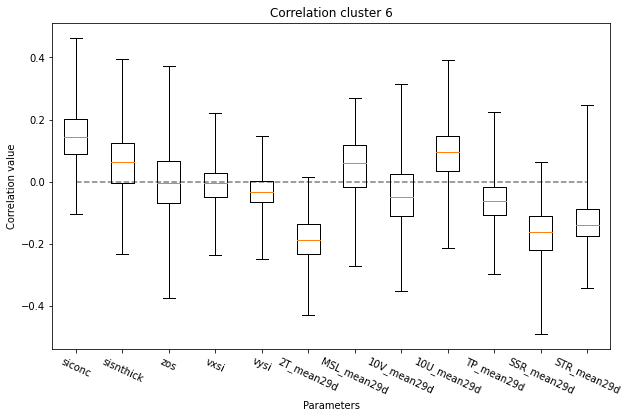

In [341]:
plot_stats_1_cluster(y_kmeans, corr_nonan, 6, nvar_names)


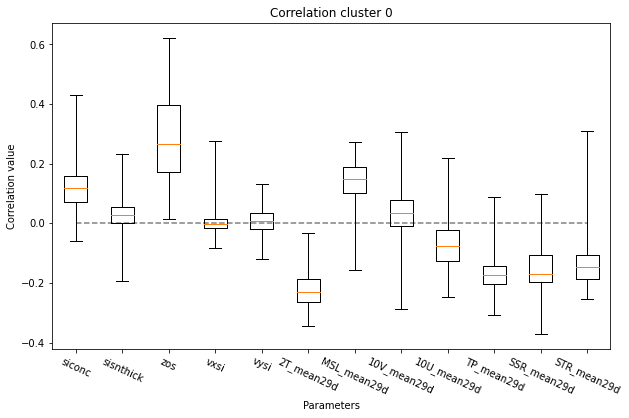

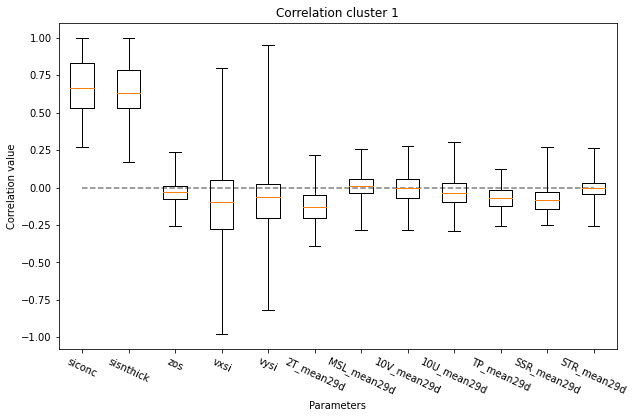

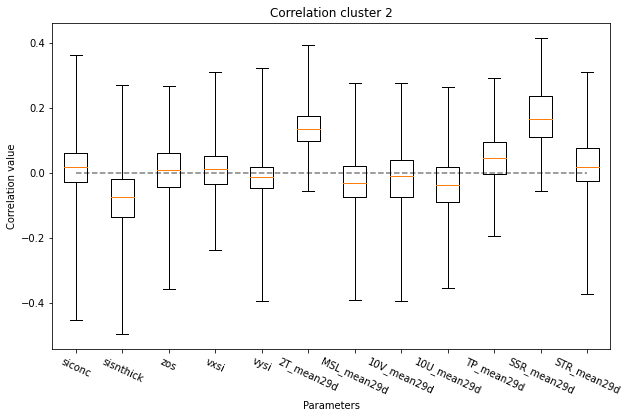

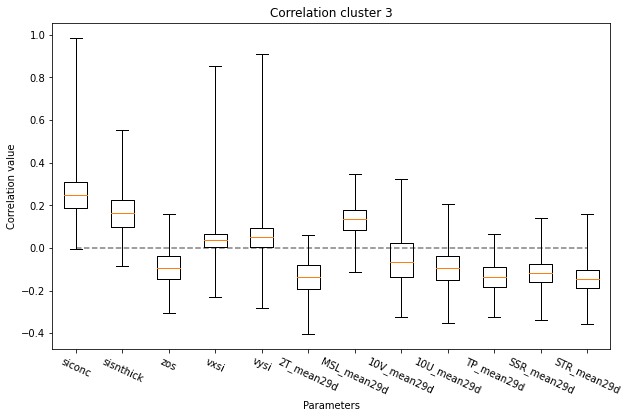

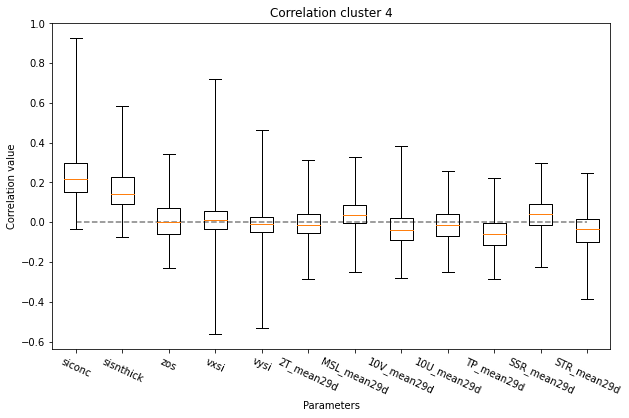

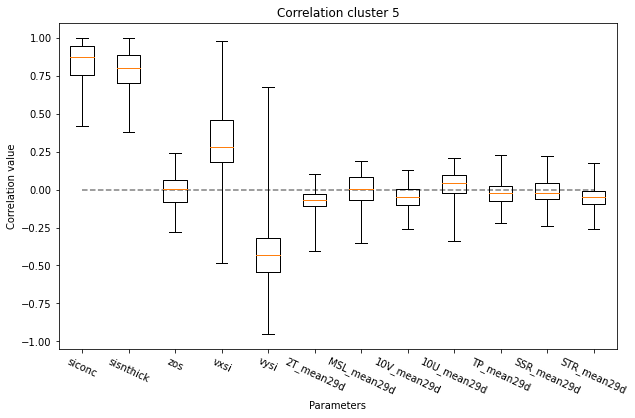

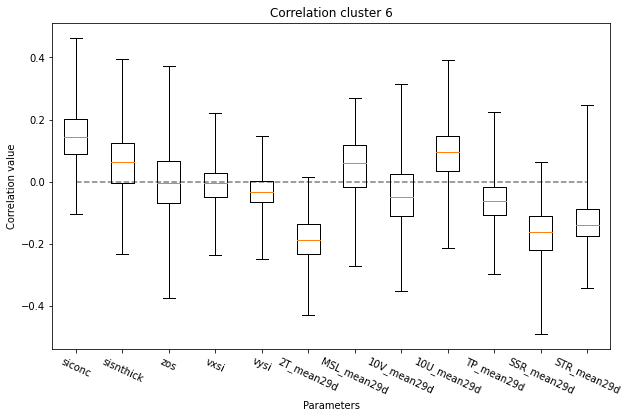

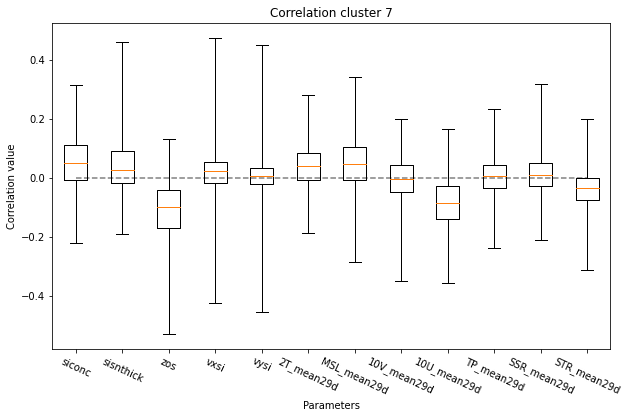

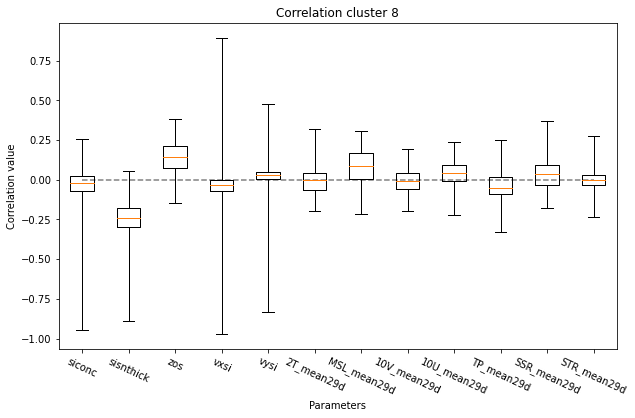

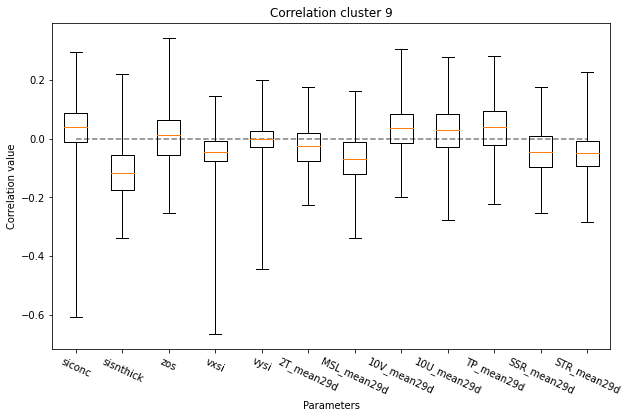

In [334]:
for ncl in range(n_clusters):
    plot_stats_1_cluster(y_kmeans, corr_nonan, ncl, nvar_names)

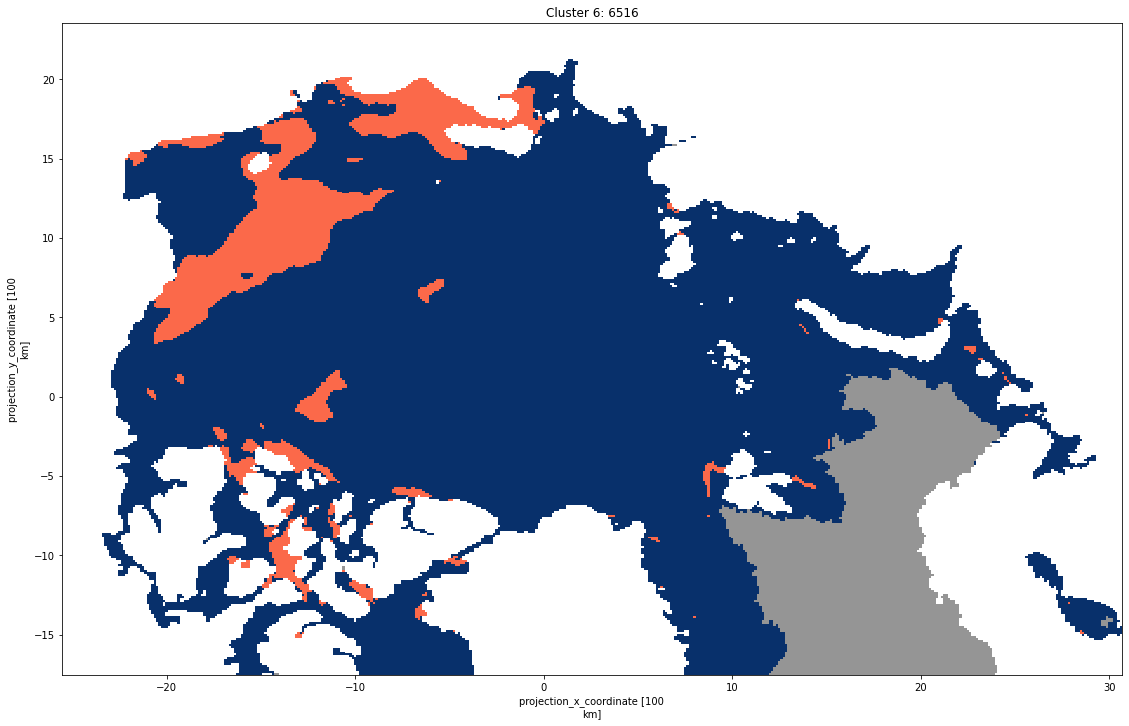

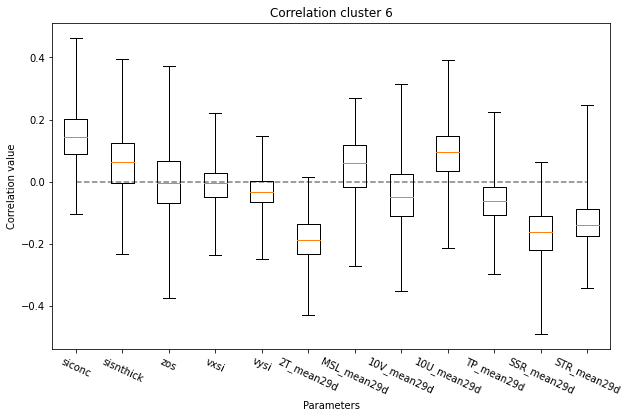

In [367]:
plot_1cluster(cluster_sel, km_xr )
plot_stats_1_cluster(y_kmeans, corr_nonan, cluster_sel, nvar_names)

# The End

Idea:
- for the chosen cluster, observe the correlations with the others data to pick more relevant input feature
- reajust the area by removing the least well predicted points